<a href="https://colab.research.google.com/github/AnnaNik334743/PDA23-24/blob/master/practice4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Наши текстовые вставки написаны курсивом, чтобы их можно было отличить от текста преподавателя.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')


from warnings import filterwarnings
filterwarnings('ignore')


PATH = '/content/drive/MyDrive/Вузовское/PDA/'

Mounted at /content/drive


# Постановка задачи и загрузка данных

В рамках практики по обработке текста поработаем с реальными данными, содержательно близкими к данным с первой практики, - из Конструктора ОП. В этот раз поработаем с описанием дисциплин с помощью языковых моделей.


Задача на практику - предобработать датасет:
1. получить текстовое описание каждой дисциплины датасета
2. выполнить предобработку текстовых данных
3. построить для дисциплины вектор на основе word2vec
4. потестировать текстовые представления

Задач не много, но все затратные по времени.

In [5]:
!gdown 1onuImgIOYhiqwnBuFsDnvepD2R5Gkebi  # takes 15 seconds

Downloading...
From: https://drive.google.com/uc?id=1onuImgIOYhiqwnBuFsDnvepD2R5Gkebi
To: /content/df_up_courses_202308.csv
100% 1.88G/1.88G [00:23<00:00, 80.2MB/s]


Из информации о дисциплине у нас есть следующая:
1. course_id - номер дисциплины (может повторяться)
2. course_title - название дисциплины
3. description - краткое описание дисциплины
4. section - разделы дисциплины
5. topic - темы, входящие в раздел дисциплины
6. qualification - уровень образования (бакалавриат, магистратура, специалитет)
7. unit_id - айди факульета
8. up_id - айди учебного плана (образовательной прогарммы)
9. up_title - название учебного плана (образовательной прогарммы)
10. start_year - год набора
11. module_name - название модуля, в который входит дисциплина

In [2]:
import pandas as pd
import numpy as np
import random
import re
from IPython.display import HTML


def print_info(df, title="Dataframe"):
  display(HTML(f"<b>{title}</b>"))
  print(f"Кол-во строк: {df.shape[0]}, кол-во столбцов: {df.shape[1]}")
  display(pd.concat([df.dtypes.to_frame('Data type'),
                   df.isna().sum().to_frame('Count NaN'),
                   df.nunique().to_frame('Count unique')], axis=1).T)
  print("Sample rows:")
  display(df.sample(5))
  print()

In [6]:
DF = pd.read_csv("/content/df_up_courses_202308.csv", index_col='Unnamed: 0')
print_info(DF)

Кол-во строк: 1039709, кол-во столбцов: 11


,course_id,course_title,description,section,topic,qualification,unit_id,up_id,up_title,start_year,module_name
Data type,int64,object,object,object,object,object,float64,int64,object,int64,object
Count NaN,0,0,1676,0,0,0,0,0,0,0,0
Count unique,7118,4070,4641,15142,56139,4,55,514,202,6,1021


Sample rows:


,course_id,course_title,description,section,topic,qualification,unit_id,up_id,up_title,start_year,module_name
6977406,22681,Экспериментальные методы клеточной биологии,Данный курс покажет вам одновременно высокую т...,Лекция по теме Применение информационных техно...,Чем информационные технологии помогают в клето...,All_levels,40.0,7216,ФудТех / Foodtech,2022,Общеуниверситетские факультативы
471622,13950,Основы организации международных научных иссле...,International Research Management Essentials (...,Project Management Tools,Gantt charts,master,22.0,7009,Проектирование киберфизических систем защиты и...,2020,Элективная дисциплина Soft Skills
1220460,14959,Основы иммунологии / Basics of Immunology,Students will know how the immune response unf...,Antineoplastic immunity and immunotherapy,"Tumor-associated macrophages, T cells",master,28.0,6934,Информационные технологии в энергетике,2019,Общеуниверситетские факультативы
3073844,15934,Основы исследовательской деятельности,Данный факультатив знакомит студентов с основа...,Порядок написания научных статей и их публикация,Этапы написания научной статьи,All_levels,40.0,7312,Низкотемпературная техника и энергетика,2020,Общеуниверситетские факультативы
3190306,15937,Математика в машинном обучении,В эпоху постоянных изменений: меняются тренды ...,Методы функционального анализа в машинном обуч...,Машинное обучение как задача сходимости в прос...,All_levels,29.0,6986,Молекулярная биология и биотехнология / Molecu...,2020,Факультативные дисциплины


*У некоторых дисциплин отсутствуют описания. Потенциально это может создать проблему. Исправим ситуацию.*

In [7]:
DF.fillna('', inplace=True)

## Предобработка датасета

Преобразуйте датасет так, чтобы одна строка описывала одну дисциплину в учебном плане. Отдельным столбцом должен храниться весь текст, который описывает дисциплину: description, section, topic. Без дубликатов содержания разделов и тем внутри дисциплины.

*Одна и та же дисциплина может реализовываться в разные года в разных учебных планах, поэтому раз перед нами стоит задача склейки описания, разделов и тем, выделим из датасета эти данные, обработаем их независимо, а затем вернем на место. Это позволит работать с меньшим объемом данных и более эффективно выполнять запросы.*

*Мы не имеем информации о том, в каком порядке идут темы каждого раздела. Будем ориентироваться на индекс, исходя из предположения, что чем он меньше, тем раньше шла тема.*

In [26]:
COURSE_DF = DF[['course_id', 'description', 'section', 'topic']].drop_duplicates()
print_info(COURSE_DF)

Кол-во строк: 104097, кол-во столбцов: 4


,course_id,description,section,topic
Data type,int64,object,object,object
Count NaN,0,0,0,0
Count unique,7118,4642,15142,56139


Sample rows:


,course_id,description,section,topic
5836985,19523,"Курс раскрывает правовые, нормативные, экономи...",Аудит систем менеджмента качества.,Виды и методология аудита.
4074284,12582,Mastering knowledge on the main problems of th...,Global healthcare markets,Advanced foreign experience and domestic devel...
2471190,14119,В данном курсе студенты изучат основы информат...,Основы информатики и вычислительной техники,Лекция 1. Информатизация и место информатики к...
2377939,4184,"Дисциплина ""Прикладная голография"" знакомит ст...",Приложения голографии,Защитная голография
3018301,16333,Дисциплина ''Теория и методы проектирования оп...,Этапы проектирования оптических систем,Стартовая система


In [ ]:
def add_period_after_word(text):
    result = re.sub(r'(\w+)(\n+)', r'\1.\2', text)
    if result[-1] not in '.!?':
        result += '.'
    return result


def transform_course_info(df):
    description = df['description'].iloc[0]
    section_topic = df.groupby('section')['topic'].agg(lambda x: '\n'.join(x)).reset_index()
    section_topic = '\n\n\n'.join(section_topic['section'] + '\n\n' + section_topic['topic'])
    overall_course_description = description + '\n\n\n\n' + section_topic
    return pd.DataFrame({'description': [description],
                         'section_topic': [section_topic],
                         'overall_course_description': [overall_course_description]})


COURSE_DF_MERGED = COURSE_DF.groupby('course_id').apply(transform_course_info).reset_index().drop(columns='level_1')  # weird col

In [ ]:
DF = pd.merge(DF.drop(columns=['description', 'section', 'topic']).drop_duplicates(),
              COURSE_DF_MERGED, on='course_id').drop_duplicates().sort_values(['course_id', 'start_year'])  # там 166 NaN в описании, если не делать fillna в начале
DF['overall_course_description'] = DF['course_title'] + '\n\n\n\n' + DF['overall_course_description']
DF['overall_course_description'] = DF['overall_course_description'].apply(add_period_after_word)

print_info(DF)

Кол-во строк: 66076, кол-во столбцов: 11


,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,description,section_topic,overall_course_description
Data type,int64,object,object,float64,int64,object,int64,object,object,object,object
Count NaN,0,0,0,0,0,0,0,0,0,0,0
Count unique,7118,4070,4,55,514,202,6,1021,4642,5844,6266


Sample rows:


,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,description,section_topic,overall_course_description
28437,9789,Биометрия и нейротехнологии,bachelor,12.0,6919,Компьютерные технологии в дизайне,2019,Элективный модуль по группе направлений (выбра...,"Курс знакомит с основами формирования, методам...",Программные средства для обработки и анализа б...,Биометрия и нейротехнологии.\n\n\n\nКурс знако...
37767,15948,Полная базовая подготовка к экзамену IELTS Aca...,All_levels,9.0,7002,Электроинженерия,2020,Факультативные дисциплины,The IELTS Extended Academic course implies ful...,IELTS Academic Listening\n\nExam practice\nTyp...,Полная базовая подготовка к экзамену IELTS Aca...
35443,10242,Инновационная экономика и технологическое пред...,bachelor,21.0,7014,Программирование и интернет-технологии,2020,Модуль «Предпринимательская культура»,Данная дисциплина нацелена на развитие теорети...,Unit-экономика\n\nМетрики. Количество привлече...,Инновационная экономика и технологическое пред...
6828,14941,Основы практического инвестирования: подходы и...,master,1.0,7137,Компьютерные системы и технологии,2021,Общеуниверситетские факультативы,В ходе изучения дисциплины студенты познакомят...,Основные инвестиционные инструменты\n\nУправле...,Основы практического инвестирования: подходы и...
11643,12516,Управление проектной деятельностью,master,6.0,7323,Технологии и системы преобразования энергии,2021,Модуль обязательных дисциплин,Освоение дисциплины «Управление проектной деят...,Два подхода к проектному управлению: классичес...,Управление проектной деятельностью.\n\n\n\nОсв...


*На примере одной дисциплины продемонстрируем логику обработки описания, разделов и тем.*

In [ ]:
display(COURSE_DF[COURSE_DF['course_id'] == 3974])
print()
print(DF[DF['course_id'] == 3974]['overall_course_description'].values[0])

,course_id,description,section,topic
2290481,3974,Дисциплина знакомит студентов с методами сбора...,Введение в компьютерную лингвистику,Основные понятия компьютерной лингвистики
2290489,3974,Дисциплина знакомит студентов с методами сбора...,Введение в компьютерную лингвистику,Задачи компьютерной лингвистики
2290497,3974,Дисциплина знакомит студентов с методами сбора...,Методы сбора текстовых данных,Веб-скрейпинг
2290505,3974,Дисциплина знакомит студентов с методами сбора...,Методы сбора текстовых данных,Сбор данных через API
2290513,3974,Дисциплина знакомит студентов с методами сбора...,Обработка текста,Этапы предобработки текста
2290521,3974,Дисциплина знакомит студентов с методами сбора...,Обработка текста,Векторное представление текста
2290529,3974,Дисциплина знакомит студентов с методами сбора...,Обработка текста,Регулярные выражения
2290537,3974,Дисциплина знакомит студентов с методами сбора...,Методы анализа текстовых данных,Морфологический анализ текста
2290545,3974,Дисциплина знакомит студентов с методами сбора...,Методы анализа текстовых данных,Классификация текстовых данных
2290553,3974,Дисциплина знакомит студентов с методами сбора...,Методы анализа текстовых данных,Тематическое моделирование



Компьютерная лингвистика.



Дисциплина знакомит студентов с методами сбора, обработки и анализа текстовых данных.



Введение в компьютерную лингвистику.

Основные понятия компьютерной лингвистики.
Задачи компьютерной лингвистики.


Методы анализа текстовых данных.

Морфологический анализ текста.
Классификация текстовых данных.
Тематическое моделирование.


Методы сбора текстовых данных.

Веб-скрейпинг.
Сбор данных через API.


Обработка текста.

Этапы предобработки текста.
Векторное представление текста.
Регулярные выражения.


*На всякий случай проверим, что у нас не случилось полностью пустых РПД.*

In [ ]:
DF[DF['overall_course_description'].apply(lambda text: len(text.strip())) == 0]

,course_id,course_title,qualification,unit_id,up_id,up_title,start_year,module_name,description,section_topic,overall_course_description


Преобразования выполняются не слишком быстро, рекомендую сохраниться.

## Предобработка описания дисциплины

Пора поработать со столбцом с текстовым содержанием дисциплины. Минимально понадобятся следующие шаги предобработки:
1. Токенизация
2. Удаление пунктуации
3. Лемматизация
4. Удаление лишних пробелов внутри текста

Чтобы не слишком углубляться в предобработку, рекомендую воспользоваться реализованными в gensim методами. Примеры можно найти в ноутбуке по ссылке: https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing

*Несколько моментов, которые хочется отметить:*

*1. Лемматизация для Word2Vec используется только в случае, когда мало данных для обучения. Обычно его обучают на сырых данных. Кроме того, удаление пунктуации в тематической структуре (да и в целом) применительно к Word2Vec кажется странным, потому что склеиваются конец одной темы и начало следующей.*

*2. Тематическую структуру можно попробовать отобразить на множество именных словосочетаний ([древняя, но интересная публикация по теме](https://www.dialog-21.ru/media/1645/20.pdf)) и далее строить эмбеддинги по ним или просто измерять схожесть мерой Жаккара.*

*Алгоритмы на `overall_course_description`: TF-IDF (полный цикл предобработки), Word2Vec (полный цикл предобработки), Word2Vec (токенизация only), [rubert-tiny2](https://huggingface.co/cointegrated/rubert-tiny2), Doc2Vec.*

*Нефункциональные требования: код должен представлять собой легко адаптируемый под новые данные пайплайн.*

In [ ]:
COURSE_DF_MERGED = DF[['course_id', 'course_title', 'description',
                       'section_topic', 'overall_course_description']].drop_duplicates()  # в overall_course_description было добавлено название курса
print_info(COURSE_DF_MERGED)

Кол-во строк: 7118, кол-во столбцов: 5


,course_id,course_title,description,section_topic,overall_course_description
Data type,int64,object,object,object,object
Count NaN,0,0,0,0,0
Count unique,7118,4070,4642,5844,6266


Sample rows:


,course_id,course_title,description,section_topic,overall_course_description
33991,20504,Оптико-информационные приборы,"В дисциплине ""Оптико-информационные приборы"" р...",Оптико-информационные приборы\n\nОптико-информ...,Оптико-информационные приборы.\n\n\n\nВ дисцип...
63707,25226,Турецкий язык,Турецкий язык для начинающих,Тема 1. Встреча и знакомство.\n\nДиалоги: Офиц...,Турецкий язык.\n\n\n\nТурецкий язык для начина...
34081,10793,Методы визуализации данных,В ходе изучения дисциплины студенты знакомятся...,Методы визуализации данных\n\nОсновные виды гр...,Методы визуализации данных.\n\n\n\nВ ходе изуч...
37695,19620,Программирование,"Дисциплина ""Программирование"" включает в себя ...",Дополнительные элементы стандартной библиотеки...,"Программирование.\n\n\n\nДисциплина ""Программи..."
2048,7222,Материаловедение,"Материаловедение - область знаний, изучающая п...",Современные машиностроительные материалы. Про...,Материаловедение.\n\n\n\nМатериаловедение - об...


*Предобработка.*

In [3]:
%%capture
!pip install neattext natasha pymorphy2 pymystem3==0.1.10

In [4]:
%%capture
from tqdm.notebook import tqdm
import re
from collections import Counter

from neattext.functions import *
from neattext.pipeline import TextPipeline
from pymystem3 import Mystem
from razdel import tokenize as natasha_tokenize
import nltk
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = stopwords.words('russian') + stopwords.words('english') + [
    'a', 'about', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be',
    'been', 'but', 'by', 'can', 'could', 'do', 'for', 'from', 'has', 'have',
    'i', 'if', 'in', 'is', 'it', 'me', 'my', 'no', 'not', 'of', 'on', 'one',
    'or', 'so', 'that', 'the', 'them', 'there', 'they', 'this', 'to', 'was',
    'we', 'what', 'which', 'will', 'with', 'would', 'you', 'а', 'будем', 'будет',
    'будете', 'будешь', 'буду', 'будут', 'будучи', 'будь', 'будьте', 'бы', 'был',
    'была', 'были', 'было', 'быть', 'в', 'вам', 'вами', 'вас', 'весь', 'во', 'вот',
    'все', 'всё', 'всего', 'всей', 'всем', 'всём', 'всеми', 'всему', 'всех', 'всею',
    'всея', 'всю', 'вся', 'вы', 'да', 'для', 'до', 'его', 'едим', 'едят', 'ее',
    'её', 'ей', 'ел', 'ела', 'ем', 'ему', 'емъ', 'если', 'ест', 'есть', 'ешь',
    'еще', 'ещё', 'ею', 'же', 'за', 'и', 'из', 'или', 'им', 'ими', 'имъ', 'их',
    'к', 'как', 'кем', 'ко', 'когда', 'кого', 'ком', 'кому', 'комья', 'которая',
    'которого', 'которое', 'которой', 'котором', 'которому', 'которою', 'которую',
    'которые', 'который', 'которым', 'которыми', 'которых', 'кто', 'меня', 'мне',
    'мной', 'мною', 'мог', 'моги', 'могите', 'могла', 'могли', 'могло', 'могу',
    'могут', 'мое', 'моё', 'моего', 'моей', 'моем', 'моём', 'моему', 'моею',
    'можем', 'может', 'можете', 'можешь', 'мои', 'мой', 'моим', 'моими', 'моих',
    'мочь', 'мою', 'моя', 'мы', 'на', 'нам', 'нами', 'нас', 'наса', 'наш', 'наша',
    'наше', 'нашего', 'нашей', 'нашем', 'нашему', 'нашею', 'наши', 'нашим', 'нашими',
    'наших', 'нашу', 'не', 'него', 'нее', 'неё', 'ней', 'нем', 'нём', 'нему', 'нет',
    'нею', 'ним', 'ними', 'них', 'но', 'о', 'об', 'один', 'одна', 'одни', 'одним',
    'одними', 'одних', 'одно', 'одного', 'одной', 'одном', 'одному', 'одною', 'одну',
    'он', 'она', 'оне', 'они', 'оно', 'от', 'по', 'при', 'с', 'сам', 'сама', 'сами',
    'самим', 'самими', 'самих', 'само', 'самого', 'самом', 'самому', 'саму', 'свое',
    'своё', 'своего', 'своей', 'своем', 'своём', 'своему', 'своею', 'свои', 'свой',
    'своим', 'своими', 'своих', 'свою', 'своя', 'себе', 'себя', 'собой', 'собою',
    'та', 'так', 'такая', 'такие', 'таким', 'такими', 'таких', 'такого', 'такое',
    'такой', 'таком', 'такому', 'такою', 'такую', 'те', 'тебе', 'тебя', 'тем',
    'теми', 'тех', 'то', 'тобой', 'тобою', 'того', 'той', 'только', 'том', 'томах',
    'тому', 'тот', 'тою', 'ту', 'ты', 'у', 'уже', 'чего', 'чем', 'чём', 'чему',
    'что', 'чтобы', 'эта', 'эти', 'этим', 'этими', 'этих', 'это', 'этого', 'этой',
    'этом', 'этому', 'этот', 'этою', 'эту', 'я', 'мені', 'наші', 'нашої', 'нашій',
    'нашою', 'нашім', 'ті', 'тієї', 'тією', 'тії', 'теє', 'очень', 'вновь', 'казаться',
    'nan', 'всё', 'это', 'твой', 'свой', 'весь', 'вообще',
    'пусть', 'ещё', 'который', 'её', 'словно', 'пока',
    'сколько', 'сквозь', 'чей', 'вокруг', 'любой', 'слишком', 'почему',
    'среди', 'значит', 'ваш', 'тысяча', 'однажды', 'сегодня',
    'завтра', 'вчера', 'послезавтра', 'позавчера', 'нибыть', 'точно',
    'уметь', 'целый', 'полный', 'часть', 'делать',
    'готовый', 'хотя', 'как', 'столько', 'равно', 'оно', 'похожий',
    'скоро', 'разный', 'всякий', 'порой', 'часто', 'настоящий', 'вместо',
    'вовсе', 'иметь', 'вроде', 'лишь', 'также', 'млн', 'руб',
    'наверное', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь',
    'девять', 'десять', 'пускай', 'мимо', 'частый', 'сей', 'привет',
    'наверно', 'туда', 'иль', 'возможно', 'вено', 'иной', 'едва',
    'поэтому', 'впереди', 'зря', 'вообще', 'меж', 'мол', 'нету', 'наш',
    'иначе', 'всякий', 'ради', 'оттого', 'нечего', 'скорее',
    'пред', 'сначала', 'вряд', 'случайно', 'коль', 'многий', 'кроме',
    'откуда', 'нынче', 'ибо', 'порою', 'вне', 'кой', 'еле', 'разом',
    'либо', 'зато', 'сорок', 'везде', 'таков', 'вон', 'покуда',
    'затем', 'особенно', 'несмотря', 'сотый', 'всюду',
    'возле', 'кстати', 'прям', 'ныне', 'бай', 'предельно',
    'чрез', 'некий', 'впредь', 'практически', 'лишь', 'каждый',
    'день', 'год', 'мочь', 'коли', 'найти', 'нужно', 'снова',
    "друг", "коллега", "блок", "лекция", "семинар", "вебинар", "урок", "курс",
    "модуль", "тренинг", "практикум", "мастер-класс", "туториал", "студент",
    "преподаватель", "лектор", "учитель", "обучающийся",
    "группа", "класс", "аудитория", "куратор", "задание", "проект",
    "домашний", "работа", "экзамен", "тест", "оценка", "дедлайн", "кредит",
    "аттестация", "сертификация", "учебный", "план", "образовательная",
    "программа", "академическая степень", "исследование",
    "методические указания", "учебник", "конспект",
    "понимание", "случай", "идея", "задание", "первый", "второй",
    "практика", "чиселка", "лайфхак", "понятие", "плюсик", "профессия",
    "внимание", "штука", "текст", "страничка", "color", "центр",
    "доллар", "стиль", "отступ", "файл", "экран", "пример", "hello",
    "этап", "давать", "задача"
]

In [5]:
MYSTEM = Mystem()

NEATTEXT_PIPELINE = TextPipeline(steps=[remove_html_tags, remove_urls,
                                        remove_emails, remove_puncts,
                                        remove_numbers])

def simple_preprocessing(text, remove_stopwords=True):
    """
      Простая предобработка текста, состоящая из:
       1) приведения текста к нижнему регистру
       2) удаления html-тэгов, url, email-ов, пунктуации и чисел
       3) лемматизации
       4) удаления стоп-слов
       6) удаления лишних пробельных символов
    """
    step1 = text.lower()
    step2 = re.sub(r"[^-а-яёa-z ]", " ",
                   NEATTEXT_PIPELINE.transform(step1))
    lemmas = MYSTEM.lemmatize(step2)
    if remove_stopwords:
      lemmas = [word for word in lemmas if word not in STOPWORDS]
    step4 = "".join(lemmas).strip()
    step5 = re.sub(r"\s+", " ", step4).strip()
    return step5


def tokenize_text(text):
  return [_.text for _ in natasha_tokenize(text)]

In [ ]:
COURSE_DF_MERGED['overall_course_description_simple_preprocessing'] = COURSE_DF_MERGED['overall_course_description'].apply(simple_preprocessing)
COURSE_DF_MERGED['overall_course_description_simple_preprocessing_tokenized'] = COURSE_DF_MERGED['overall_course_description_simple_preprocessing'].apply(tokenize_text)

COURSE_DF_MERGED['overall_course_description_tokenized_only'] = COURSE_DF_MERGED['overall_course_description'].apply(lambda text: tokenize_text(text.lower()))

*Создадим колонку `section_topic_terms`. Код был написан командой "Дети МХ" (преимущественно Даниилом Пятыго) в рамках хакатона Цифровой прорыв. Мы также пробовали дообучить NER, но в силу малого количества качественных обучающих данных и нехватки времени rule-based показал более хорошие результаты.*

*В среднем 2 секунды на РПД с пост-обработкой.*

*Upd: выбросили всю пост-обработку и возвращаем список именных словосочетаний. Причина - время.*

In [6]:
import pymorphy2


MORPH = pymorphy2.MorphAnalyzer()

# правило — последовательность слов (список) с их частями речи и падежами
MORPH_RULES = [
    [{"POS": "NOUN", "case": ["nomn", "accs"]}],
    [{"POS": "ADJF", "case": ["nomn", "accs"]}, {"POS": "NOUN", "case": ["nomn", "accs"]}],
    [{"POS": "NOUN", "case": ["nomn", "accs"]}, {"POS": "NOUN", "case": ["gent"]}],
    [{"POS": "NOUN", "case": ["nomn", "accs"]}, {"POS": "ADJF", "case": ["gent"]}, {"POS": "NOUN", "case": ["gent"]}],
    [{"POS": "ADJF", "case": ["nomn", "accs"]}, {"POS": "ADJF", "case": ["nomn", "accs"]}, {"POS": "NOUN", "case": ["nomn", "accs"]}],
    [{"POS": "ADJF", "case": ["nomn", "accs"]}, {"POS": "NOUN", "case": ["nomn", "accs"]}, {"POS": "NOUN", "case": ["gent"]}]
]

ENGLISH_RULE = re.compile("[A-Za-z\d-]{3,}(?:\s+[A-Za-z\d-]{3,})*")


def match_morph_rule(text, rule):
    result = False
    words = text.split()
    if len(words) != len(rule):
        return False
    flag = False
    for word, rule_part in zip(words, rule):
        parsed = MORPH.parse(word)[0]
        if parsed.tag.POS != rule_part["POS"]:
            flag = True
        if parsed.tag.case not in rule_part["case"]:
            flag = True
    if not flag:
        result = True
    return result


def exclude_stopwords(tokens):
    return [word for word in tokens if word.lower() not in STOPWORDS]


def preprocess(text, lowercase=True):  # частично позаимствовали этот кусок, всё остальное писали сами
    text = text.replace("\n", "")
    text = re.sub(r"( - |- )", r" ", text)
    text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)
    text = re.sub(r"([0-9]+).([0-9]+)", "", text)
    text = re.sub(r"([0-9]+).(\s+)", "", text)
    text = re.sub(r"[:\.,»«)(\n\t–]", ". ", text)
    text = re.sub(r"([а-яa-zё]+)([А-ЯA-ZЁ]+)", r"\1. \2", text)
    text = re.sub(r"([0-9]+)(\s+)([0-9]+)", "", text)
    text = re.sub(r"\.(\s+)([a-zA-Zа-яА-ЯёЁ0-9\-])", lambda x: x.group(0).upper(), text)
    text = text.replace("\xa0", " ")
    text = text.replace(".", ". ").strip()
    if lowercase:
        return re.findall(r'\b\w+\b', text.lower())
    return re.findall(r'\b\w+\b', text)


def find_english_terms(text):
    return list(ENGLISH_RULE.findall(text))


def find_morph_terms(text, stopwords=False):
    terms = []
    tokens = preprocess(text)
    if stopwords:
        tokens = exclude_stopwords(tokens)

    for i in range(len(tokens)):
        eng_result = find_english_terms(' '.join(tokens[i:i+3]))
        if eng_result:
            terms.extend(eng_result)
        for rule in MORPH_RULES:
            phrase = ' '.join(tokens[i:i+len(rule)])
            if match_morph_rule(phrase, rule):
                terms.append(phrase)

    return terms


# strong: если хотя бы один из токенов термина — стопслово, то удаляем термин
# иначе удаляем только токен, оставляем остаток термина
def filter_terms(terms, strong=False):
    filtered_terms = []

    for term in terms:
        words = term.split()
        normalized_words = [MORPH.parse(word)[0].normal_form for word in words]
        if strong:
            if not any(word in STOPWORDS for word in normalized_words):
                filtered_terms.append(term)
        else:
            result = ' '.join([words[i] for i in range(len(words)) if normalized_words[i] not in STOPWORDS])
            if result != "":
                filtered_terms.append(result)

    return filtered_terms


def get_terms_candidates(text, strong=False):
    terms = find_morph_terms(text)
    return filter_terms(list(terms), strong=strong)


def normalize_terms(words):
    return [MORPH.parse(word)[0].normal_form for word in words]


def normalize_frequencies(frequencies):
    max_freq = max(frequencies.values()) if len(frequencies.values()) > 0 else 1
    return {term: freq / max_freq for term, freq in frequencies.items()}


def filter_terms_by_frequency(terms, threshold=0.1):
    term_frequencies = Counter(terms)
    normalized_frequencies = normalize_frequencies(term_frequencies)
    filtered_terms = {term: freq for term, freq in normalized_frequencies.items() if freq >= threshold}
    return filtered_terms


def finalize_terms(terms, filtered_terms):
    return [term for term in terms if term in filtered_terms.keys()]


def favour_longer(termins):
    one_words = []
    not_one_words = []
    for term in termins:
        if ' ' in term:
            not_one_words.append(term)
        else:
            one_words.append(term)
    not_one_words_str = ' '.join(not_one_words)
    overall = []
    for word in termins:
        if word in one_words:
            if not re.search(rf'\b{re.escape(word)}\b', not_one_words_str):
                overall.append(word)
        else:
            overall.append(word)
    return overall


def get_terms(text):  # the pipeline
    terms = get_terms_candidates(text, strong=True)
    cleared_terms = filter_terms_by_frequency(terms)
    final_terms_unique = list(cleared_terms.keys())
    res = favour_longer(final_terms_unique)
    return res

In [ ]:
COURSE_DF_MERGED['section_topic_terms'] = COURSE_DF_MERGED['overall_course_description'].apply(get_terms)

## Векторизация

*В связи с тем, что векторизация rubert-ом не требует обучения, имеет смысл откинуть дубликаты для ускорения работы, поэтому продолжим работать не с полным датасетом, а с COURSE_DF_MERGED.*

***Rubert.***
*Примерно 0.33 секунды на текст.*

In [ ]:
%%capture
!pip install rusenttokenize faiss-cpu transformers sentence_transformers sentencepiece accelerate bitsandbytes

In [ ]:
from rusenttokenize import ru_sent_tokenize
from sentence_transformers import SentenceTransformer


RUBERT = SentenceTransformer('cointegrated/rubert-tiny2')


def get_rubert_embedding_for_text(text):
    sentences = ru_sent_tokenize(text)
    embeddings = RUBERT.encode(sentences)
    return embeddings.mean(axis=0)

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

.gitignore:   0%|          | 0.00/6.00 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/118M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tinybert-ru-labse-adapter-v2.pt:   0%|          | 0.00/963k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
embeddings = COURSE_DF_MERGED['overall_course_description'].apply(get_rubert_embedding_for_text).values
COURSE_DF_MERGED['rubert_vector'] = embeddings

*Вернемся обратно к полному датасету.*

In [ ]:
DF = pd.merge(DF.drop(columns=['course_title', 'description', 'section_topic', 'overall_course_description']).drop_duplicates(), COURSE_DF_MERGED, on='course_id')

***TF-IDF***

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack


tfidf_vectorizer = TfidfVectorizer(max_features=312, analyzer='word', ngram_range=(1, 3), tokenizer=tokenize_text)
tfidf_matrix = tfidf_vectorizer.fit_transform(DF['overall_course_description_simple_preprocessing'])
tfidf_array = tfidf_matrix.toarray()

DF['tfidf_vector'] = [tfidf_array[i, :] for i in range(tfidf_array.shape[0])]

***Word2Vec***

In [7]:
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
import gensim


def embed(tokens, w2v_model):
    # функция для получения вектора дисциплины по векторам слов из ее описания
    # среднее по всем векторам
    n = 0
    embeddings = np.zeros(w2v_model.vector_size)
    for token in tokens:
        try:
            n += 1
            embeddings += w2v_model.wv.get_vector(token)
        except KeyError:
            pass
    return embeddings / (n if n != 0 else 1)

In [ ]:
%time
W2V_PR_TOK = Word2Vec(DF['overall_course_description_simple_preprocessing_tokenized'].tolist(),
                      min_count=5, vector_size=312, workers=4, window=7)

W2V_PR_TOK.save(PATH + 'models/w2v_pr_tok')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [ ]:
W2V_PR_TOK.wv.most_similar(["машинный", "обучение"])

[('нейросетевой', 0.45861679315567017),
 ('кластеризация', 0.45566004514694214),
 ('нейронный', 0.42610231041908264),
 ('текстовый', 0.411171019077301),
 ('глубокий', 0.39651668071746826),
 ('нейросеть', 0.3948373794555664),
 ('регрессия', 0.3876897096633911),
 ('программирование', 0.3825506567955017),
 ('фреймворка', 0.381417453289032),
 ('тренировочный', 0.3813093304634094)]

In [ ]:
DF['w2v_pr_tok_vector'] = DF['overall_course_description_simple_preprocessing_tokenized'].apply(lambda tokens: embed(tokens, W2V_PR_TOK))

In [8]:
W2V_PR_TOK = gensim.models.Word2Vec.load(PATH + 'models/w2v_pr_tok')

*Изначально была мысль о том, что Word2Vec даст нормальные результаты на данных без предобработки. Но, видимо, у нас слишком мало данных. Мы попробовали и выяснили, что результаты получаются куда менее качественные.*

In [ ]:
%time
W2V_TOK = Word2Vec(DF['overall_course_description_tokenized_only'].tolist(),
                      min_count=5, vector_size=312, workers=4, window=7)

W2V_TOK.save(PATH + 'models/w2v_tok')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
W2V_TOK.wv.most_similar(["машинное", "обучение"])

[('неподготовленному', 0.5560559630393982),
 ('глубокое', 0.5362081527709961),
 ('вуц', 0.5280274748802185),
 ('высказыванию', 0.5264928936958313),
 ('активизацию', 0.5154974460601807),
 ('дегустаторов', 0.4978793263435364),
 ('подкреплением', 0.4816751778125763),
 ('приёмам', 0.4675646722316742),
 ('туманные', 0.4670216143131256),
 ('ранжированию', 0.4664970934391022)]

In [ ]:
DF['w2v_tok_vector'] = DF['overall_course_description_tokenized_only'].apply(lambda tokens: embed(tokens, W2V_TOK))

In [ ]:
# W2V_TOK = gensim.models.Word2Vec.load(PATH + 'models/w2v_tok')

*Word2Vec чисто по терминам, которые навыделял наш алгоритм. Такое себе, если честно.*

In [ ]:
%time
W2V_STT = Word2Vec(DF['section_topic_terms'].tolist(),
                      min_count=1, vector_size=312, workers=4, window=11)

W2V_STT.save(PATH + 'models/w2v_stt')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [ ]:
W2V_STT.wv.most_similar(["машинное обучение"])

[('методы машинного обучения', 0.8930089473724365),
 ('регуляризация', 0.8631697297096252),
 ('torch', 0.8566267490386963),
 ('семантический поиск', 0.8459343314170837),
 ('дифференциальные операторы', 0.8445367813110352),
 ('подготовка исходных данных', 0.8401443958282471),
 ('классификацию', 0.8396448493003845),
 ('самостоятельное выстраивание', 0.8314291834831238),
 ('функции ошибки', 0.8312910199165344),
 ('автоматический синтез', 0.828279435634613)]

In [ ]:
DF['w2v_stt_vector'] = DF['section_topic_terms'].apply(lambda tokens: embed(tokens, W2V_STT))

In [ ]:
# W2V_STT = gensim.models.Word2Vec.load(PATH + 'models/w2v_stt')

***Doc2Vec***

*Результаты интересные, но не слишком осмысленные в случае коротких документов. Если же передавать не термины, а текст, то сравнение идет по структуре текста. В общем, для данной задачи не рекомендую.*

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


corpus = DF['section_topic_terms'].tolist()
tagged_data = [TaggedDocument(doc, tags=[str(i)]) for i, doc in enumerate(corpus)]

D2V_STT = Doc2Vec(vector_size=312, window=11, min_count=1, workers=4, epochs=10)
D2V_STT.build_vocab(tagged_data)
D2V_STT.train(tagged_data, total_examples=D2V_STT.corpus_count, epochs=D2V_STT.epochs)

D2V_STT.save(PATH + 'models/d2v_stt')

In [ ]:
DF['d2v_stt_vector'] = [D2V_STT.dv[i] for i in range(len(corpus))]

In [ ]:
# D2V_STT = gensim.models.Doc2Vec.load(PATH + 'models/d2v_stt')

***Оценка.*** *Попробуем оценить эмбеддинги "на глаз".*

In [9]:
from sklearn.metrics.pairwise import cosine_similarity


def jaccard_similarity(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

*Абсолютное отображение.*

In [ ]:
vector_cols = ['tfidf_vector', 'rubert_vector', 'w2v_pr_tok_vector', 'w2v_tok_vector', 'w2v_stt_vector', 'd2v_stt_vector', 'section_topic_terms']
courses_ids = [2658, 2833, 22350, 10304, 15584, 22213, 11206, 11240, 13071]  # первые три - Программирование, дальше три Биохимии и три Фотоники
test_df = DF[DF.course_id.isin(courses_ids)].drop_duplicates(['course_id']).set_index('course_id')[vector_cols].reindex(courses_ids)


for vector_col in vector_cols:
    sample_test_df = pd.DataFrame(0, index=courses_ids, columns=courses_ids)
    for i in sample_test_df.index:
        for j in sample_test_df.columns:
            if i == j:
                sample_test_df.at[i, j] = np.nan
            else:
                if vector_col != 'section_topic_terms':
                    sample_test_df.at[i, j] = cosine_similarity(test_df.loc[i][vector_col].reshape(1, -1),
                                                          test_df.loc[j][vector_col].reshape(1, -1))[0][0]
                else:
                    sample_test_df.at[i, j] = jaccard_similarity(test_df.loc[i]['section_topic_terms'],
                                                        test_df.loc[j]['section_topic_terms'])
    sample_test_df = sample_test_df.style.background_gradient(cmap='Blues', vmin=0, vmax=1)
    print(vector_col)
    display(sample_test_df)
    print()

tfidf_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.293553,0.342150,0.219789,0.176307,0.032219,0.067596,0.035170,0.017500
2833,0.293553,nan,0.494989,0.105523,0.030165,0.044757,0.059116,0.016889,0.047784
22350,0.342150,0.494989,nan,0.145684,0.145704,0.028867,0.047175,0.022715,0.038704
10304,0.219789,0.105523,0.145684,nan,0.480828,0.403698,0.061066,0.045224,0.028959
15584,0.176307,0.030165,0.145704,0.480828,nan,0.380257,0.016765,0.005479,0.011969
22213,0.032219,0.044757,0.028867,0.403698,0.380257,nan,0.030614,0.014486,0.014183
11206,0.067596,0.059116,0.047175,0.061066,0.016765,0.030614,nan,0.418471,0.699040
11240,0.035170,0.016889,0.022715,0.045224,0.005479,0.014486,0.418471,nan,0.406941
13071,0.017500,0.047784,0.038704,0.028959,0.011969,0.014183,0.699040,0.406941,nan



rubert_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.899501,0.967257,0.899875,0.919792,0.846379,0.885682,0.874891,0.884778
2833,0.899501,nan,0.926002,0.830583,0.814596,0.784806,0.835000,0.836703,0.843446
22350,0.967257,0.926002,nan,0.888584,0.888074,0.837291,0.889750,0.884151,0.876601
10304,0.899875,0.830583,0.888584,nan,0.976394,0.974161,0.882633,0.883809,0.880241
15584,0.919792,0.814596,0.888074,0.976394,nan,0.945609,0.861335,0.854057,0.870236
22213,0.846379,0.784806,0.837291,0.974161,0.945609,nan,0.846516,0.846755,0.832225
11206,0.885682,0.835000,0.889750,0.882633,0.861335,0.846516,nan,0.959378,0.950432
11240,0.874891,0.836703,0.884151,0.883809,0.854057,0.846755,0.959378,nan,0.946259
13071,0.884778,0.843446,0.876601,0.880241,0.870236,0.832225,0.950432,0.946259,nan



w2v_pr_tok_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.848225,0.961423,0.486628,0.419184,0.338098,0.431010,0.381838,0.394403
2833,0.848225,nan,0.868806,0.487605,0.293961,0.294568,0.430311,0.428238,0.568595
22350,0.961423,0.868806,nan,0.408842,0.324680,0.239664,0.430095,0.371337,0.427251
10304,0.486628,0.487605,0.408842,nan,0.890409,0.933469,0.521807,0.549898,0.536757
15584,0.419184,0.293961,0.324680,0.890409,nan,0.951298,0.427128,0.421975,0.303133
22213,0.338098,0.294568,0.239664,0.933469,0.951298,nan,0.361739,0.416684,0.326940
11206,0.431010,0.430311,0.430095,0.521807,0.427128,0.361739,nan,0.859160,0.858160
11240,0.381838,0.428238,0.371337,0.549898,0.421975,0.416684,0.859160,nan,0.839887
13071,0.394403,0.568595,0.427251,0.536757,0.303133,0.326940,0.858160,0.839887,nan



w2v_tok_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.886388,0.955066,0.767368,0.706958,0.676643,0.681300,0.730021,0.658954
2833,0.886388,nan,0.852870,0.746458,0.577467,0.621628,0.594328,0.684320,0.720105
22350,0.955066,0.852870,nan,0.779188,0.632966,0.641842,0.706047,0.712508,0.654458
10304,0.767368,0.746458,0.779188,nan,0.836461,0.938498,0.794662,0.810131,0.771122
15584,0.706958,0.577467,0.632966,0.836461,nan,0.908964,0.763782,0.732379,0.620666
22213,0.676643,0.621628,0.641842,0.938498,0.908964,nan,0.763296,0.809304,0.700774
11206,0.681300,0.594328,0.706047,0.794662,0.763782,0.763296,nan,0.897198,0.836890
11240,0.730021,0.684320,0.712508,0.810131,0.732379,0.809304,0.897198,nan,0.856736
13071,0.658954,0.720105,0.654458,0.771122,0.620666,0.700774,0.836890,0.856736,nan



w2v_stt_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.903113,0.789196,0.872961,0.661980,0.839417,0.629409,0.824758,0.506310
2833,0.903113,nan,0.855545,0.911138,0.573743,0.844623,0.628988,0.786298,0.537078
22350,0.789196,0.855545,nan,0.829953,0.635636,0.757406,0.571510,0.659810,0.393021
10304,0.872961,0.911138,0.829953,nan,0.756120,0.946664,0.772565,0.853751,0.612000
15584,0.661980,0.573743,0.635636,0.756120,nan,0.765528,0.783102,0.694190,0.544942
22213,0.839417,0.844623,0.757406,0.946664,0.765528,nan,0.761069,0.877593,0.606430
11206,0.629409,0.628988,0.571510,0.772565,0.783102,0.761069,nan,0.833862,0.833775
11240,0.824758,0.786298,0.659810,0.853751,0.694190,0.877593,0.833862,nan,0.634484
13071,0.506310,0.537078,0.393021,0.612000,0.544942,0.606430,0.833775,0.634484,nan



d2v_stt_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.167599,0.351160,0.605574,0.439417,0.534591,0.517827,0.302304,-0.252832
2833,0.167599,nan,0.081548,0.162167,-0.202239,-0.087921,-0.031090,-0.110038,0.206782
22350,0.351160,0.081548,nan,0.318454,0.330341,0.208382,0.151738,-0.061009,-0.131296
10304,0.605574,0.162167,0.318454,nan,0.802887,0.797080,0.582012,0.264600,-0.196943
15584,0.439417,-0.202239,0.330341,0.802887,nan,0.798752,0.621974,0.314396,-0.239303
22213,0.534591,-0.087921,0.208382,0.797080,0.798752,nan,0.607033,0.429099,-0.206383
11206,0.517827,-0.031090,0.151738,0.582012,0.621974,0.607033,nan,0.641261,0.229103
11240,0.302304,-0.110038,-0.061009,0.264600,0.314396,0.429099,0.641261,nan,0.391531
13071,-0.252832,0.206782,-0.131296,-0.196943,-0.239303,-0.206383,0.229103,0.391531,nan



section_topic_terms


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.010204,0.013889,0.000000,0.000000,0.000000,0.000000,0.010417,0.000000
2833,0.010204,nan,0.047619,0.020202,0.000000,0.000000,0.007246,0.000000,0.000000
22350,0.013889,0.047619,nan,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000
10304,0.000000,0.020202,0.013514,nan,0.043011,0.041237,0.005917,0.000000,0.000000
15584,0.000000,0.000000,0.000000,0.043011,nan,0.031250,0.000000,0.000000,0.000000
22213,0.000000,0.000000,0.000000,0.041237,0.031250,nan,0.000000,0.000000,0.000000
11206,0.000000,0.007246,0.000000,0.005917,0.000000,0.000000,nan,0.007353,0.026316
11240,0.010417,0.000000,0.000000,0.000000,0.000000,0.000000,0.007353,nan,0.000000
13071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,nan


*Относительное отображение.*

In [ ]:
for vector_col in vector_cols:
    sample_test_df = pd.DataFrame(0, index=courses_ids, columns=courses_ids)
    for i in sample_test_df.index:
        for j in sample_test_df.columns:
            if i == j:
                sample_test_df.at[i, j] = np.nan
            else:
                if vector_col != 'section_topic_terms':
                    sample_test_df.at[i, j] = cosine_similarity(test_df.loc[i][vector_col].reshape(1, -1),
                                                          test_df.loc[j][vector_col].reshape(1, -1))[0][0]
                else:
                    sample_test_df.at[i, j] = jaccard_similarity(test_df.loc[i]['section_topic_terms'],
                                                        test_df.loc[j]['section_topic_terms'])
    sample_test_df = sample_test_df.style.background_gradient(cmap='Greens')
    print(vector_col)
    display(sample_test_df)
    print()

tfidf_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.293553,0.342150,0.219789,0.176307,0.032219,0.067596,0.035170,0.017500
2833,0.293553,nan,0.494989,0.105523,0.030165,0.044757,0.059116,0.016889,0.047784
22350,0.342150,0.494989,nan,0.145684,0.145704,0.028867,0.047175,0.022715,0.038704
10304,0.219789,0.105523,0.145684,nan,0.480828,0.403698,0.061066,0.045224,0.028959
15584,0.176307,0.030165,0.145704,0.480828,nan,0.380257,0.016765,0.005479,0.011969
22213,0.032219,0.044757,0.028867,0.403698,0.380257,nan,0.030614,0.014486,0.014183
11206,0.067596,0.059116,0.047175,0.061066,0.016765,0.030614,nan,0.418471,0.699040
11240,0.035170,0.016889,0.022715,0.045224,0.005479,0.014486,0.418471,nan,0.406941
13071,0.017500,0.047784,0.038704,0.028959,0.011969,0.014183,0.699040,0.406941,nan



rubert_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.899501,0.967257,0.899875,0.919792,0.846379,0.885682,0.874891,0.884778
2833,0.899501,nan,0.926002,0.830583,0.814596,0.784806,0.835000,0.836703,0.843446
22350,0.967257,0.926002,nan,0.888584,0.888074,0.837291,0.889750,0.884151,0.876601
10304,0.899875,0.830583,0.888584,nan,0.976394,0.974161,0.882633,0.883809,0.880241
15584,0.919792,0.814596,0.888074,0.976394,nan,0.945609,0.861335,0.854057,0.870236
22213,0.846379,0.784806,0.837291,0.974161,0.945609,nan,0.846516,0.846755,0.832225
11206,0.885682,0.835000,0.889750,0.882633,0.861335,0.846516,nan,0.959378,0.950432
11240,0.874891,0.836703,0.884151,0.883809,0.854057,0.846755,0.959378,nan,0.946259
13071,0.884778,0.843446,0.876601,0.880241,0.870236,0.832225,0.950432,0.946259,nan



w2v_pr_tok_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.848225,0.961423,0.486628,0.419184,0.338098,0.431010,0.381838,0.394403
2833,0.848225,nan,0.868806,0.487605,0.293961,0.294568,0.430311,0.428238,0.568595
22350,0.961423,0.868806,nan,0.408842,0.324680,0.239664,0.430095,0.371337,0.427251
10304,0.486628,0.487605,0.408842,nan,0.890409,0.933469,0.521807,0.549898,0.536757
15584,0.419184,0.293961,0.324680,0.890409,nan,0.951298,0.427128,0.421975,0.303133
22213,0.338098,0.294568,0.239664,0.933469,0.951298,nan,0.361739,0.416684,0.326940
11206,0.431010,0.430311,0.430095,0.521807,0.427128,0.361739,nan,0.859160,0.858160
11240,0.381838,0.428238,0.371337,0.549898,0.421975,0.416684,0.859160,nan,0.839887
13071,0.394403,0.568595,0.427251,0.536757,0.303133,0.326940,0.858160,0.839887,nan



w2v_tok_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.886388,0.955066,0.767368,0.706958,0.676643,0.681300,0.730021,0.658954
2833,0.886388,nan,0.852870,0.746458,0.577467,0.621628,0.594328,0.684320,0.720105
22350,0.955066,0.852870,nan,0.779188,0.632966,0.641842,0.706047,0.712508,0.654458
10304,0.767368,0.746458,0.779188,nan,0.836461,0.938498,0.794662,0.810131,0.771122
15584,0.706958,0.577467,0.632966,0.836461,nan,0.908964,0.763782,0.732379,0.620666
22213,0.676643,0.621628,0.641842,0.938498,0.908964,nan,0.763296,0.809304,0.700774
11206,0.681300,0.594328,0.706047,0.794662,0.763782,0.763296,nan,0.897198,0.836890
11240,0.730021,0.684320,0.712508,0.810131,0.732379,0.809304,0.897198,nan,0.856736
13071,0.658954,0.720105,0.654458,0.771122,0.620666,0.700774,0.836890,0.856736,nan



w2v_stt_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.903113,0.789196,0.872961,0.661980,0.839417,0.629409,0.824758,0.506310
2833,0.903113,nan,0.855545,0.911138,0.573743,0.844623,0.628988,0.786298,0.537078
22350,0.789196,0.855545,nan,0.829953,0.635636,0.757406,0.571510,0.659810,0.393021
10304,0.872961,0.911138,0.829953,nan,0.756120,0.946664,0.772565,0.853751,0.612000
15584,0.661980,0.573743,0.635636,0.756120,nan,0.765528,0.783102,0.694190,0.544942
22213,0.839417,0.844623,0.757406,0.946664,0.765528,nan,0.761069,0.877593,0.606430
11206,0.629409,0.628988,0.571510,0.772565,0.783102,0.761069,nan,0.833862,0.833775
11240,0.824758,0.786298,0.659810,0.853751,0.694190,0.877593,0.833862,nan,0.634484
13071,0.506310,0.537078,0.393021,0.612000,0.544942,0.606430,0.833775,0.634484,nan



d2v_stt_vector


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.167599,0.351160,0.605574,0.439417,0.534591,0.517827,0.302304,-0.252832
2833,0.167599,nan,0.081548,0.162167,-0.202239,-0.087921,-0.031090,-0.110038,0.206782
22350,0.351160,0.081548,nan,0.318454,0.330341,0.208382,0.151738,-0.061009,-0.131296
10304,0.605574,0.162167,0.318454,nan,0.802887,0.797080,0.582012,0.264600,-0.196943
15584,0.439417,-0.202239,0.330341,0.802887,nan,0.798752,0.621974,0.314396,-0.239303
22213,0.534591,-0.087921,0.208382,0.797080,0.798752,nan,0.607033,0.429099,-0.206383
11206,0.517827,-0.031090,0.151738,0.582012,0.621974,0.607033,nan,0.641261,0.229103
11240,0.302304,-0.110038,-0.061009,0.264600,0.314396,0.429099,0.641261,nan,0.391531
13071,-0.252832,0.206782,-0.131296,-0.196943,-0.239303,-0.206383,0.229103,0.391531,nan



section_topic_terms


,2658,2833,22350,10304,15584,22213,11206,11240,13071
2658,nan,0.010204,0.013889,0.000000,0.000000,0.000000,0.000000,0.010417,0.000000
2833,0.010204,nan,0.047619,0.020202,0.000000,0.000000,0.007246,0.000000,0.000000
22350,0.013889,0.047619,nan,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000
10304,0.000000,0.020202,0.013514,nan,0.043011,0.041237,0.005917,0.000000,0.000000
15584,0.000000,0.000000,0.000000,0.043011,nan,0.031250,0.000000,0.000000,0.000000
22213,0.000000,0.000000,0.000000,0.041237,0.031250,nan,0.000000,0.000000,0.000000
11206,0.000000,0.007246,0.000000,0.005917,0.000000,0.000000,nan,0.007353,0.026316
11240,0.010417,0.000000,0.000000,0.000000,0.000000,0.000000,0.007353,nan,0.000000
13071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,nan


*Подводя итог: проделали кучу работы, чтобы убедиться в том, что предложенный в ТЗ алгоритм построения векторного пространства работает лучше всего.*

Не забываем сохраниться!

*Сохранить придется не всё, иначе оно работает миллион лет.*

In [ ]:
DF[['course_id', 'qualification', 'unit_id', 'up_id', 'up_title',
   'start_year', 'module_name', 'course_title', 'description',
   'section_topic', 'overall_course_description', 'overall_course_description_simple_preprocessing',
   'overall_course_description_simple_preprocessing_tokenized',
   'section_topic_terms', 'w2v_pr_tok_vector']].to_csv(PATH + 'data/df.csv', index=False)

*Чуть-чуть верхнеуровнево посмотрим, что получается. [Код отсюда.](https://medium.com/@marcusa314/visualizing-words-377624cb20c7)*

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize


axes = [0, 1, 2]

colors = ["tab:red", "tab:blue", "tab:green", "tab:orange",
          "tab:purple", "tab:olive", "tab:pink", "tab:cyan", "tab:gray"]
defaultcolor = "black"

sizes = []
defaultsize = 16


def plot2D(result, wordgroups):
    pyplot.scatter(result[:, axes[0]], result[:, axes[1]])
    for g, group in enumerate(wordgroups):
        for word in group:
            if not word in words:
                continue
            i = words.index(word)
            # Create plot point
            coord = (result[i, axes[0]], result[i, axes[1]])
            color = colors[g] if g < len(colors) else defaultcolor
            size = sizes[g] if g < len(sizes) else defaultsize
            pyplot.annotate(word, xy=coord, color=color, fontsize=size)


def plot3D(result, wordgroups):
    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result[:, axes[0]], result[:, axes[1]], result[:, axes[2]])
    for g, group in enumerate(wordgroups):
        for word in group:
            if not word in words:
                continue
            i = words.index(word)
            # Create plot point
            color = colors[g] if g < len(colors) else defaultcolor
            size = sizes[g] if g < len(sizes) else defaultsize
            ax.text(result[i, axes[0]], result[i, axes[1]],
                    result[i, axes[2]], word, color=color, fontsize=size)


def get_groups(words, model, clusterK):
    vecs = {w: model.wv.get_vector(w) for w in words}

    # Assign groups if using clustering
    if clusterK > 0:
        estimator = KMeans(init='k-means++', n_clusters=clusterK, n_init=50)
        estimator.fit_predict(model.wv[vecs])
        groups = [[] for n in range(clusterK)]
        for i, w in enumerate(vecs.keys()):
            group = estimator.labels_[i]
            groups[group].append(w)

    return words, groups, vecs

*Будем честны, выглядит не очень.*

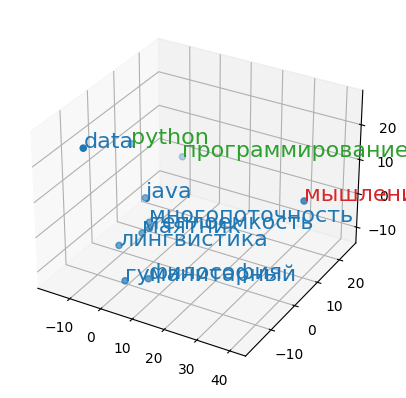

In [ ]:
words = ['программирование', 'python', 'java', 'многопоточность',
          'гуманитарный', 'философия', 'мышление', 'лингвистика',
          'data', 'теплоемкость', 'маятник']
clusterK = 3

model = gensim.models.Word2Vec.load(PATH + 'models/w2v_tok')
words, groups, vecs = get_groups(words, model, clusterK)
coords = model.wv[vecs]

pca = PCA(n_components=max(axes)+1)
result = pca.fit_transform(coords)

if len(axes) > 2:
    plot3D(result, groups)
else:
    plot2D(result, groups)
pyplot.show()

*TODO: хочется построить графовую модель корпуса на основе структуры w2v, но мы и так уже не укладываемся в дедлайн.*

# Задание на ЛР2

С предобработанными данными попытаемся решить следующие задачи:

1. Определить предметные области дисциплин через кластеризацию. Используем два классических алгоритма: k-means и иерархическую кластеризацию.
2. Найти дисциплины, которые выбиваются из учебного плана. Для этого построим эмбеддинг учебного плана (усредним эмбеддинги всех его дисциплин) и найдем дисциплины, у которых минимальное косинусное сходство с эмбеддингом учебного плана.
3. Оценить, насколько удачно будет генерировать содержание дисциплины LLM. Структура описания дисциплины не важна. Важно содержание. Сравнивать будем эмбеддинги снова через косинусное сходство.

*Проблема с конвертированием типов и её решение.*

In [10]:
import pandas as pd
import numpy as np


DF = pd.read_csv(PATH + 'data/df.csv')

list_cols = ['section_topic_terms', 'overall_course_description_simple_preprocessing_tokenized'] # 'overall_course_description_tokenized_only'
arr_cols = ['w2v_pr_tok_vector']  # 'tfidf_vector', 'w2v_pr_tok_vector', 'w2v_tok_vector', 'w2v_stt_vector', 'd2v_stt_vector', 'rubert_vector'

for col in list_cols:
    DF[col] = DF[col].apply(eval)

for col in arr_cols:
    DF[col] = DF[col].apply(lambda x:
                            np.fromstring(
                            x.replace('\n','')
                            .replace('[','')
                            .replace(']','')
                            .replace('  ',' '), sep=' '))

## Кластеризация дисциплин

Удалим дубликаты, т.к. нас интересует только содержательный аспект в данной задаче.

In [ ]:
DF_TO_CLUST = DF.drop_duplicates(subset=["course_id"], keep="first")
f"{DF.shape} -> {DF_TO_CLUST.shape}"

'(66076, 15) -> (7118, 15)'

In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X = scaler.fit_transform(np.vstack(DF_TO_CLUST.w2v_pr_tok_vector.values))  # на всякий случай...

### k-means

7к объектов - небольшое количество для кластеризации, обучение будет проходить достаточно быстро. Начнем с k-means. В качестве меры сходства будем использовать косинусное расстояние. Другие виды расстояния будут мало репрезентативны на векторах размером 300.

Видно, что не только по количеству объектов, но и содержательно кажется, что разбиение в целом адекватное. Оцените качество кластеризации с помощью метрики "силуэт" из sklearn.

Подберите оптимальное количество кластером по методу локтя. Протестируйте результат и оцените качество кластеризации с оптимальным количеством кластеров.

*Думаю, имеет смысл начать с метода локтя, чтобы определиться с оптимальным количеством кластеров.*

*Не нашла в sklearn готовой реализации KMeans с косинусным расстоянием под капотом, но зато нашла, что косинусное расстояние связано с евклидовым линейно.*

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.graph_objs as go


xaxs = list(range(2, 51))

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "random_state": 42,
    "algorithm": "lloyd"
}

silhouette_scores = []
sse = []
for k in xaxs:  # takes 6 minutes
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


trace_sse = go.Scatter(x=xaxs, y=sse, mode='lines+markers', name='SSE')

trace_silhouette = go.Scatter(x=xaxs, y=silhouette_scores,
                              mode='lines+markers', name='SS', yaxis='y2')

layout = go.Layout(
    title='Elbow Method for Optimal k with Silhouette Score',
    xaxis=dict(title='Number of Clusters'),
    yaxis=dict(title='SSE (Sum of Squared Errors)'),
    yaxis2=dict(title='Silhouette Score', overlaying='y', side='right'),
    legend=dict(x=0.7, y=0.9),
    hovermode='closest'
)

fig = go.Figure(data=[trace_sse, trace_silhouette], layout=layout)
fig.show()

*12 выглядит неплохо.*

In [ ]:
kmeans = KMeans(n_clusters=12, **kmeans_kwargs)
kmeans.fit(X)
DF_TO_CLUST["cluster_kmeans"] = kmeans.labels_
DF_TO_CLUST.cluster_kmeans.value_counts()

1     1109
10     720
4      715
0      683
8      610
7      587
3      574
6      525
5      479
9      384
2      374
11     358
Name: cluster_kmeans, dtype: int64

Разделение на кластеры получилось удивительно ровное. Посмотрим, будет ли какой-то смысл в примерах объектов кластеров.

> **В коде ниже берутся первые 5 примеров. Посмотрите, что будет на случайных подвыборках.**

*Чтобы оценить данные в совокупности, посмотрим на ключевые слова в кластерах. Для достижения желаемого применим TF-IDF.*

In [ ]:
for i in range(kmeans.n_clusters):
  sample_df = DF_TO_CLUST.loc[DF_TO_CLUST.cluster_kmeans == i]

  tfidf_vectorizer = TfidfVectorizer(max_features=312, tokenizer=tokenize_text)
  tfidf_matrix = tfidf_vectorizer.fit_transform(sample_df['overall_course_description_simple_preprocessing'])
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).mean()

  print(f"Cluster: {i}. Keywords: ", ', '.join(tfidf_df.nlargest(20).index.tolist()))
  display(sample_df.sample(5))
  print()

Cluster: 0. Keywords:  научный, язык, метод, анализ, деятельность, наука, основной, знание, иностранный, дизайн, основа, система, коммуникация, развитие, социальный, решение, технология, управление, дисциплина, история


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
43848,21001,master,15.0,7249,Научная коммуникация,2022,Обязательные дисциплины,Эффективные политики в управлении наукой и обр...,На этой дисциплине студенты получат базовое пр...,Введение в науковедение. Структура современной...,Эффективные политики в управлении наукой и обр...,эффективный политик управление наука образован...,"[эффективный, политик, управление, наука, обра...","[базовое представление, кейсы, введение, науко...","[-0.29016395, -0.29499203, 0.1288781, -0.29062...",0
9684,5387,master,17.0,6996,Программное обеспечение интеллектуальных систе...,2020,Профильный профессиональный модуль,Интеллектуальные системы и базы знаний,Приступая к изучению дисциплины студенту необх...,"Интеллектуальные системы, основанные на знания...",Интеллектуальные системы и базы знаний.\n\n\n\...,интеллектуальный система база знание приступат...,"[интеллектуальный, система, база, знание, прис...","[моменты, вопросы, срок, материал, литературны...","[-0.07427591, 0.06546759, 0.41792729, -0.23602...",0
46128,21232,All_levels,48.0,6866,Молекулярное питание и пищевые технологии,2018,Факультативные дисциплины,Основы эффективной прокрастинации,Прокрастинация имеет выраженную негативную кон...,Академическая прокрастинация\n\nОсобенности ак...,Основы эффективной прокрастинации.\n\n\n\nПрок...,основа эффективный прокрастинация прокрастинац...,"[основа, эффективный, прокрастинация, прокраст...","[прокрастинацию, академическая прокрастинация]","[-0.08282735, -0.146898363, 0.139081717, -0.17...",0
92,2637,bachelor,22.0,6860,Информационные технологии в энергетике,2018,Модуль «Soft Skills»,"Техники публичных выступлений, переговоров и п...",Данный курс сформирован на основе лучших дост...,Взаимодействие с аудиторией\n\nРабота с возраж...,"Техники публичных выступлений, переговоров и п...",техника публичный выступление переговоры презе...,"[техника, публичный, выступление, переговоры, ...","[деловая коммуникация, вопросы, взаимодействие...","[-0.23471464, -0.1144995, 0.30908722, -0.22102...",0
62929,24319,master,54.0,7470,Цифровые методы в гуманитарных исследованиях,2023,Факультативные дисциплины,Цифровая гуманитаристика,Основная задача данного курса - предложить раз...,"Библиотеки, архивы, энциклопедии, история big...",Цифровая гуманитаристика.\n\n\n\nОсновная зада...,цифровой гуманитаристика основной данный предл...,"[цифровой, гуманитаристика, основной, данный, ...","[цифровая гуманитаристика, процессы, инструмен...","[0.0170627953, -0.194233603, 0.151759017, -0.2...",0



Cluster: 1. Keywords:  systems, methods, research, optical, data, analysis, course, materials, design, quantum, control, management, students, development, basic, project, system, scientific, principles, information


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
17898,12948,master,42.0,7336,Индустриальная экология / Industrial ecology,2021,Профессиональный модуль,Теория и практика обращения с отходами /Theory...,Objectives of the discipline: -Study of the ba...,Basic concepts and principles of waste managem...,Теория и практика обращения с отходами /Theory...,теория обращение отходы theory practice waste ...,"[теория, обращение, отходы, theory, practice, ...","[waste management, formation, waste management...","[-0.08245159, 0.21675744, 0.18185626, 0.130357...",1
39421,18377,master,34.0,7205,Биоинженерия и биотехнические системы / Bioeng...,2022,Дисциплины на английском языке,Биотехнические системы / Biotechnical Systems,The course reveals the concept of biotechnical...,"The concept of ""biotechnical system""\n\nSystem...",Биотехнические системы / Biotechnical Systems....,биотехнический система biotechnical systems co...,"[биотехнический, система, biotechnical, system...","[biotechnical systems, creation principles des...","[0.167098568, 0.436358617, 0.302046791, 0.0914...",1
52359,22670,All_levels,9.0,6936,Компьютерные системы и технологии,2019,Общеуниверситетские факультативы,Лаборатория академического письма / Academic W...,The primary purpose of universities as researc...,Scientific article publication process\n\nWhy ...,Лаборатория академического письма / Academic W...,лаборатория академический письмо academic writ...,"[лаборатория, академический, письмо, academic,...","[лаборатория академического письма, academic w...","[0.051281002, 0.046519553, 0.164115206, 0.0737...",1
43624,20677,master,33.0,7119,Перспективные системы передачи данных / Advanc...,2021,"Специализация ""Функциональные материалы оптоэл...",Наномеханика функциональных материалов / Nanom...,"The discipline ""Nanomechanics of Functional Ma...",MEMS and NEMS\n\nBasic concepts and definition...,Наномеханика функциональных материалов / Nanom...,наномеханика функциональный материал nanomecha...,"[наномеханика, функциональный, материал, nanom...","[наномеханика функциональных материалов, funct...","[0.13825194, 0.09343249, 0.32903408, 0.0914226...",1
28712,15564,master,3.0,6998,Радиочастотные системы и устройства,2020,Факультативные дисциплины,Прикладная спинтроника / Applied spintronics,Spintronics is a branch of quantum electronics...,Design and production of magnetic structures.\...,Прикладная спинтроника / Applied spintronics.\...,прикладной спинтроника applied spintronics spi...,"[прикладной, спинтроника, applied, spintronics...","[прикладная спинтроника, applied spintronics, ...","[0.14179114, 0.13577899, 0.26962204, 0.0379506...",1



Cluster: 2. Keywords:  квантовый, уравнение, поле, система, теория, закон, энергия, метод, газ, магнитный, состояние, движение, основной, тело, волна, механика, процесс, свойство, физика, среда


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
43482,20561,bachelor,43.0,6934,Информационные технологии в энергетике,2019,"Специализация ""Тепловые режимы приборов и устр...",Прикладная физика,В курсе представлены освещены вопросы теплопер...,Перенос тепловой энергии в диэлектриках и мета...,Прикладная физика.\n\n\n\nВ курсе представлены...,прикладной физика представлять освещать вопрос...,"[прикладной, физика, представлять, освещать, в...","[прикладная физика, вопросы теплопереноса, пер...","[-0.154575319, -0.442440169, 0.774204941, -0.0...",2
28807,15658,bachelor,3.0,6963,Прикладная и теоретическая физика,2021,"Специализация ""Моделирование физических процес...",Физика твердого тела. Часть 2,Физика твердого тела посвящена исследованию си...,Магнетизм в твердых телах\n\nДиа- и парамагнет...,Физика твердого тела. Часть 2.\n\n\n\nФизика т...,физика твердый тело физика твердый тело посвящ...,"[физика, твердый, тело, физика, твердый, тело,...","[физика твердого тела, физика материи, взаимод...","[-0.175620952, -0.396692046, 0.672350814, 0.09...",2
17982,13023,master,3.0,7124,Техническая физика / Physics and engineering,2021,"Специализация ""Физика полупроводников / Semico...",Квазичастицы в полупроводниках,Курс дает представление о современной физике и...,Колебания кристаллической решетки\n\nАкустичес...,Квазичастицы в полупроводниках.\n\n\n\nКурс да...,квазичастица полупроводник представление совре...,"[квазичастица, полупроводник, представление, с...","[представление, оптические фононы, подсистемы,...","[-0.0633726254, -0.245481877, 0.579345771, -0....",2
19527,14450,master,18.0,7005,Физика и технология наноструктур,2020,"Специализация ""Физика наноструктур""",Оптика наноразмерных супрамолекулярных систем,Содержание дисциплины охватывает вопросы теори...,Законы поглощения света\n\nЗакон поглощения св...,Оптика наноразмерных супрамолекулярных систем....,оптика наноразмерный супрамолекулярный система...,"[оптика, наноразмерный, супрамолекулярный, сис...","[оптика, содержание дисциплины, вопросы теории...","[-0.12601906, -0.33427689, 0.53465371, -0.1762...",2
27883,15155,bachelor,32.0,6915,Фотоника и оптоинформатика,2019,"Специализация ""Квантовые коммуникации и фемтот...",Специальные разделы квантовой механики и оптики,Курс “Специальные разделы квантовой механики и...,Гамильтонов формализм квантования электромагни...,Специальные разделы квантовой механики и оптик...,специальный раздел квантовый механика оптика с...,"[специальный, раздел, квантовый, механика, опт...","[специальные разделы, разделы квантовой механи...","[-0.00362458, -0.37555373, 0.4604926, -0.24569...",2



Cluster: 3. Keywords:  система, управление, проектирование, информационный, безопасность, программный, разработка, защита, обеспечение, средство, информация, процесс, требование, архитектура, технология, иса, метод, основной, производство, качество


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
43019,20472,master,12.0,7071,"Мультимедиа-технологии, дизайн и юзабилити",2021,"Специализация ""Дизайн человеко-компьютерных си...",Перспективные человеко-машинные интерфейсы,В рамках курса представляются основные техноло...,Индустрия 4.0\n\nВведение в Industry 4.0\nВирт...,Перспективные человеко-машинные интерфейсы.\n\...,перспективный человекомашинный интерфейс рамка...,"[перспективный, человекомашинный, интерфейс, р...","[перспективные человеко, машинные интерфейсы, ...","[0.00770438963, 0.104082995, 0.327219869, -0.3...",3
47762,21295,bachelor,1.0,6910,Бизнес-информатика,2019,"Специализация ""Информационные технологии в биз...",Основы UML,Курс посвящен изучению теоретических основ и п...,Концептуальное и логическое проектирование на ...,Основы UML.\n\n\n\nКурс посвящен изучению теор...,основа uml посвящать изучение теоретический ос...,"[основа, uml, посвящать, изучение, теоретическ...","[uml, основы, актуальность, важность дисциплин...","[-0.223758773, 0.117920675, 0.362312907, -0.28...",3
42121,20171,master,42.0,7263,Рециклинг и промышленный симбиоз / Recycling &...,2022,Специализация: Техническое обеспечение биореци...,Метрологическое обеспечение технологических пр...,Содержание дисциплины охватывает круг вопросов...,Калибровка и поверка средств измерений\n\nКали...,Метрологическое обеспечение технологических пр...,метрологический обеспечение технологический пр...,"[метрологический, обеспечение, технологический...","[метрологическое обеспечение, обеспечение техн...","[-0.349400122, -0.23636081, 0.405079435, -0.37...",3
9664,5367,master,12.0,7024,Компьютерные системы и технологии,2020,"Специализация ""Встраиваемые и киберфизические ...",Верификация и тестирование встраиваемых систем,Формирует систему понятий и представлений об о...,Автоматизация тестирования и верификации ВсС\n...,Верификация и тестирование встраиваемых систем...,верификация тестирование встраивать система фо...,"[верификация, тестирование, встраивать, систем...","[верификация, тестирование, систему, навыки, о...","[-0.21867719, 0.15767297, 0.44722181, -0.46267...",3
35196,16137,bachelor,13.0,6879,Технологии защиты информации,2018,"Специализация ""Организация и технология защиты...",Вычислительные сети и контроль безопасности в ...,В данном курсе обучающиеся получат Общие сведе...,Классификация угроз безопасности информации в ...,Вычислительные сети и контроль безопасности в ...,вычислительный сеть контроль безопасность комп...,"[вычислительный, сеть, контроль, безопасность,...","[контроль безопасности, классификация угроз, в...","[-0.03338272, 0.27299032, 0.30997423, -0.95084...",3



Cluster: 4. Keywords:  система, программирование, данные, язык, разработка, управление, основа, технология, проектирование, база, архитектура, основной, приложение, сеть, средство, интерфейс, тип, метод, использование, модель


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
15893,11146,master,17.0,7000,Интеллектуальные технологии в телекоммуникациях,2020,"Специализация ""Разработка и сетевое администри...",UNIX/Linux системы в инфокоммуникациях,В этом курсе вы изучите фундаментальные принци...,Вводный курс по системному администророванию\n...,UNIX/Linux системы в инфокоммуникациях.\n\n\n\...,unix linux система инфокоммуникация изучать фу...,"[unix, linux, система, инфокоммуникация, изуча...","[unix linux, принципы, навыки, утилиты, програ...","[-0.16363629, 0.26117984, 0.33368844, -0.38237...",4
41156,19584,bachelor,2.0,7287,Робототехника и искусственный интеллект,2022,Факультативные дисциплины,Операционная система Linux,В курсе даются основные понятия операционной с...,Пользовательский интерфейс операционной среды\...,Операционная система Linux.\n\n\n\nВ курсе даю...,операционный система linux даваться основной о...,"[операционный, система, linux, даваться, основ...",[linux],"[-0.142237299, 0.200601593, 0.282906491, -0.34...",4
17145,12296,master,2.0,7300,Математическое и компьютерное моделирование,2021,Модуль обязательных дисциплин,Машинное обучение и обработка данных,Данный курс представляет собой начальное введе...,Введение. Языки программирования и машинные ар...,Машинное обучение и обработка данных.\n\n\n\nД...,машинный обучение обработка данный данный пред...,"[машинный, обучение, обработка, данный, данный...","[машинное обучение, обработка данных, начально...","[-0.06528099, -0.05423013, 0.33961562, -0.3635...",4
1613,2676,bachelor,14.0,6881,Информатика и программирование,2018,Факультетский модуль,Телекоммуникационные системы и технологии,Курс «Телекоммуникационные системы и технологи...,Организация локальных вычислительных сетей\n\n...,Телекоммуникационные системы и технологии.\n\n...,телекоммуникационный система технология телеко...,"[телекоммуникационный, система, технология, те...","[технологии, tcp, особенности, оборудование, п...","[-0.108969095, 0.200723348, 0.451791195, -0.72...",4
17165,12323,master,2.0,7300,Математическое и компьютерное моделирование,2021,"Специализация ""Интеллектуальные информационные...",Теория интеллектуальных систем обработки инфор...,Данный курс представляет собой начальное введе...,"Компилятор, интерпретатор. Синтаксический анал...",Теория интеллектуальных систем обработки инфор...,теория интеллектуальный система обработка инфо...,"[теория, интеллектуальный, система, обработка,...","[теория интеллектуальных систем, начальное вве...","[-0.14654047, -0.01700104, 0.29801504, -0.3625...",4



Cluster: 5. Keywords:  оптический, лазерный, метод, система, материал, лазер, излучение, технология, основа, квантовый, основной, спектроскопия, оптика, свойство, применение, элемент, среда, свет, характеристика, принцип


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
40692,19412,bachelor,3.0,7239,Прикладная и теоретическая физика,2022,Нанооптика и оптоэлектроника,Физика лазеров,Курс «Физика лазеров» направлен на формировани...,Активные среды лазеров\n\nАктивные среды тверд...,Физика лазеров.\n\n\n\nКурс «Физика лазеров» н...,физика лазер физика лазер направлять формирова...,"[физика, лазер, физика, лазер, направлять, фор...","[физика лазеров, режимы, плазмонный лазер, фон...","[0.268434373, -0.205431153, 0.620571909, -0.31...",5
18673,13669,master,18.0,7142,Физика и технология наноструктур / Physics and...,2021,"Специализация ""Физика наноструктур для биомеди...",Методы электронной и зондовой микроскопии для ...,Курс посвящен применению электронной микроскоп...,Атомно-силовая микроскопия\n\nПринципы работы ...,Методы электронной и зондовой микроскопии для ...,метод электронный зондовый микроскопия биомеди...,"[метод, электронный, зондовый, микроскопия, би...","[интерпретация данных, крио микроскопии, силов...","[-0.10516502, -0.03008848, 0.497162, -0.329612...",5
17210,12411,master,18.0,6939,Квантовые технологии в индустрии,2021,Модуль обязательных дисциплин,"Оптические системы записи, хранения и отображе...",Курс знакомит студентов с голографическим и по...,Голографические системы\n\nОсновные особенност...,"Оптические системы записи, хранения и отображе...",оптический система запись хранение отображение...,"[оптический, система, запись, хранение, отобра...","[массоперенос, классификация светочувствительн...","[-0.11950945, -0.16406682, 0.49551718, -0.3840...",5
63366,24695,bachelor,62.0,6990,Фотоника и оптоинформатика,2020,"Специализация ""Квантовые коммуникации и фемтот...",Основы биофизики,Настоящая дисциплина относится к междисциплина...,"Арт- и биообъекты\n\nХимические связи, функцио...",Основы биофизики.\n\n\n\nНастоящая дисциплина ...,основа биофизика дисциплина относиться междисц...,"[основа, биофизика, дисциплина, относиться, ме...","[биофизики, дисциплина, различные технологии, ...","[0.04347085, -0.1279788, 0.41549021, -0.266016...",5
4448,3279,bachelor,50.0,7302,Лазерная фотоника и оптоэлектроника,2019,"Специализация ""Технологии лазерной обработки м...",Биофотоника,В данной дисциплине рассматриваются Лазерные т...,Введение в биофотонику. Лазерные технологии в ...,Биофотоника.\n\n\n\nВ данной дисциплине рассма...,биофотоника данный дисциплина рассматриваться ...,"[биофотоника, данный, дисциплина, рассматриват...","[лазерные технологии, основные оптико, физичес...","[0.16945278, -0.19439075, 0.53671323, -0.34100...",5



Cluster: 6. Keywords:  система, измерение, метод, расчет, прибор, устройство, схема, оптический, проектирование, характеристика, основной, принцип, машина, основа, процесс, средство, параметр, цепь, электрический, тепловой


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
14762,10576,bachelor,2.0,6923,Цифровые системы управления,2019,Модуль обязательных дисциплин,Электроника и схемотехника,В процессе изучения дисциплины студенты знаком...,Схемотехника аналоговых и импульсных электронн...,Электроника и схемотехника.\n\n\n\nВ процессе ...,электроника схемотехника процесс изучение дисц...,"[электроника, схемотехника, процесс, изучение,...","[электроника, полевые транзисторы, операционны...","[-0.0287088288, 0.207379068, 0.646223431, -0.3...",6
43537,20576,All_levels,44.0,7304,Лазерная фотоника и оптоэлектроника,2020,Модуль обязательных дисциплин,Конструирование оптических приборов,Дисциплина «Конструирование оптических прибор...,Конструкция типовых узлов\n\nКонструкции типов...,Конструирование оптических приборов.\n\n\n\nДи...,конструирование оптический прибор дисциплина к...,"[конструирование, оптический, прибор, дисципли...","[конструирование оптических приборов, дисципли...","[0.0638572056, 0.0441227224, 0.807151535, -0.3...",6
42107,20151,master,43.0,7262,Энергоэффективные инженерные системы и техноло...,2022,Cпециализация Экологически безопасные технолог...,Термотрансформаторы с использованием возобновл...,"Дисциплина охватывает круг вопросов, связанных...",Проектирование аппаратов термотрансформаторов\...,Термотрансформаторы с использованием возобновл...,термотрансформатор использование возобновлять ...,"[термотрансформатор, использование, возобновля...","[термотрансформаторы, дисциплина, круг вопросо...","[-0.22074363, -0.04607315, 0.36971454, -0.1566...",6
43581,20631,master,44.0,7338,Прикладная оптика / Applied optics,2021,"Специализация ""Оптические приборы и технологии""",Юстировка оптических приборов,Курс посвящен основным принципам проектировани...,Методы и средства юстировки и контроля типовых...,Юстировка оптических приборов.\n\n\n\nКурс пос...,юстировка оптический прибор посвящать основной...,"[юстировка, оптический, прибор, посвящать, осн...","[юстировка оптических приборов, оптико электро...","[-0.13171123, -0.0248244, 0.6401523, -0.316902...",6
42249,20343,bachelor,34.0,7231,Биоинженерия,2022,Энергоэффетивность,Интегрированные анализаторные комплексы,Цель - изучение практики применение устройств ...,Интегрированные анализаторные комплексы\n\nОбщ...,Интегрированные анализаторные комплексы.\n\n\n...,интегрировать анализаторный комплекс цель изуч...,"[интегрировать, анализаторный, комплекс, цель,...","[анализаторные комплексы, цель, изучение, прим...","[-0.171742328, 0.0779327718, 0.548652835, -0.3...",6



Cluster: 7. Keywords:  процесс, метод, пищевой, продукт, производство, материал, технология, система, основной, энергия, свойство, анализ, основа, химический, питание, технологический, сырье, среда, биотехнология, микроорганизм


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
43561,20609,bachelor,42.0,6955,Биотехнология,2020,"Специализация ""Экобиотехнология""",Теоретические основы процессов разделения сред,Знания:\n- знать общие принципы построения мно...,Методы и системы разделения веществ и сред\n\n...,Теоретические основы процессов разделения сред...,теоретический основа процесс разделение среда ...,"[теоретический, основа, процесс, разделение, с...","[теоретические основы, теоретические основы пр...","[-0.110594325, -0.188468524, 0.631575931, -0.1...",7
62442,24165,bachelor,42.0,6956,Биотехнология,2021,"Специализация ""Экобиотехнология""",Процессы и аппараты защиты окружающей среды,После дисциплин студенты будут знать: Знать – ...,Процессы и аппараты защиты атмосферы\n\nТермок...,Процессы и аппараты защиты окружающей среды.\n...,процесс аппарат защита окружающий среда дисцип...,"[процесс, аппарат, защита, окружающий, среда, ...","[аппараты защиты, источники выделения, окружаю...","[-0.22741583, -0.23278173, 0.55607504, -0.0864...",7
16860,12191,master,11.0,7333,Промышленная экология и чистое производство,2020,"Специализация ""Чистое производство / Cleaner P...",Основные процессы и оборудование биотехнологич...,Цель дисциплины -- приобрести компетенции в об...,Гидромеханические процессы и оборудование\n\nП...,Основные процессы и оборудование биотехнологич...,основной процесс оборудование биотехнологическ...,"[основной, процесс, оборудование, биотехнологи...","[основные процессы, оборудование, basic proces...","[-0.198252247, -0.173120712, 0.654048635, -0.0...",7
10386,6565,master,11.0,7052,Биотехнология продуктов функционального назнач...,2020,Профильный профессиональный модуль,Методология проектирования состава продуктов п...,Дисциплина нацелена на формирование у студента...,5.\tПроектирование безопасных продуктов.\n\nКа...,Методология проектирования состава продуктов п...,методология проектирование состав продукт пита...,"[методология, проектирование, состав, продукт,...","[методология проектирования, дисциплина, форми...","[-0.172925739, -0.156849348, 0.551281232, -0.1...",7
27974,15256,bachelor,34.0,6886,Биоинженерия,2020,Факультативные дисциплины,Биохимия и молекулярная биология,"В курсе изучаются основы статической биохимии,...",Белки\n\nКлассификация белков\nБиологическая р...,Биохимия и молекулярная биология.\n\n\n\nВ кур...,биохимия молекулярный биология изучаться основ...,"[биохимия, молекулярный, биология, изучаться, ...","[биохимия, молекулярная биология, основы стати...","[-0.07259764, -0.35682375, 0.45669614, -0.2768...",7



Cluster: 8. Keywords:  данные, метод, анализ, обучение, сеть, алгоритм, обработка, система, изображение, машинный, модель, нейронный, сигнал, решение, информация, данный, поиск, основа, основной, цифровой


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
21175,14910,specialist,4.0,7345,Оптико-электронные приборы и системы,2020,Модуль обязательных дисциплин,Системы видеонаблюдения,"Дисциплина посвящена системам видеонаблюдения,...",Видеоаналитика\n\nОсновные задачи видеоанлитик...,Системы видеонаблюдения.\n\n\n\nДисциплина пос...,система видеонаблюдение дисциплина посвящать с...,"[система, видеонаблюдение, дисциплина, посвяща...","[дисциплина, вопросы вормирования, основные ст...","[0.0263528017, 0.0424443712, 0.196449294, -0.4...",8
9613,5336,master,49.0,7033,Разработка программного обеспечения / Software...,2020,Факультативные дисциплины,Анализ изображений,"В дисциплине будут рассмотрены вопросы, связан...",Генеративные сети.\n\nМатрица Грама.\nРеконстр...,Анализ изображений.\n\n\n\nВ дисциплине будут ...,анализ изображение дисциплина рассматривать во...,"[анализ, изображение, дисциплина, рассматриват...","[анализ изображений, вопросы, матрица грама, р...","[0.18579912, 0.1231528, 0.33066547, -0.7675935...",8
29243,15910,bachelor,17.0,6902,Мобильные и сетевые технологии,2018,Профильный профессиональный модуль,Алгоритмы и структуры данных,Целью освоения дисциплины является достижение ...,"Алгоритмы на графах: Крускала, Дейкстры, Флойд...",Алгоритмы и структуры данных.\n\n\n\nЦелью осв...,алгоритм структура данные цель освоение дисцип...,"[алгоритм, структура, данные, цель, освоение, ...","[достижение следующих результатов, списки, гра...","[-0.106577, 0.09589672, 0.40950616, -0.4673390...",8
7548,4656,master,7.0,7061,Аналитика данных,2020,"Специализация ""Технологии анализа данных""",Анализ изображений и видео,В дисциплине рассматриваются основы обработки ...,Анализ видео\n\nОптический поток и вычитание ф...,Анализ изображений и видео.\n\n\n\nВ дисциплин...,анализ изображение видео дисциплина рассматрив...,"[анализ, изображение, видео, дисциплина, рассм...","[анализ изображений, основы обработки, сопоста...","[0.0480848458, 0.0528363104, 0.286883584, -0.7...",8
9595,5315,master,49.0,7033,Разработка программного обеспечения / Software...,2020,Профильный профессиональный модуль,Математическая статистика,"Математическая статистика — раздел математики,...",Методы снижения размерности и кластеризация\n\...,Математическая статистика.\n\n\n\nМатематическ...,математический статистика математический стати...,"[математический, статистика, математический, с...","[математическая статистика, раздел математики,...","[-0.01999619, 0.03977296, 0.41208055, -0.66167...",8



Cluster: 9. Keywords:  уравнение, метод, функция, интеграл, линейный, теория, математический, решение, ряд, свойство, система, анализ, пространство, случайный, теорема, дифференциальный, основной, вероятность, граф, порядок


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
9593,5314,master,49.0,7033,Разработка программного обеспечения / Software...,2020,"Специализация ""Software Engineering""",Математическая логика,"Математическая логика - раздел математики, изу...",Исчисление высказываний\n\nТеория вычислимости...,Математическая логика.\n\n\n\nМатематическая л...,математический логика математический логика ра...,"[математический, логика, математический, логик...","[математическая логика, раздел математики, док...","[-0.03446081, -0.16808434, 0.29614631, -0.2109...",9
40755,19493,bachelor,51.0,7241,Биотехнология,2022,Математика,Математический анализ,Математический анализ является продолжением ку...,Введение в математический анализ\n\nЛогическая...,Математический анализ.\n\n\n\nМатематический а...,математический анализ математический анализ яв...,"[математический, анализ, математический, анали...","[математический анализ, дисциплина, теоретичес...","[-0.0594232015, -0.354486037, 0.761384012, -0....",9
40369,19145,bachelor,51.0,7281,Биоинженерия,2022,Математика,Математический анализ,Математический анализ является продолжением ку...,Введение в математический анализ\n\nЛогическая...,Математический анализ.\n\n\n\nМатематический а...,математический анализ математический анализ яв...,"[математический, анализ, математический, анали...","[математический анализ, дисциплина, теоретичес...","[-0.0594232015, -0.354486037, 0.761384012, -0....",9
4702,3421,bachelor,6.0,6860,Информационные технологии в энергетике,2018,"Специализация ""Приборы и методы измерения тепл...",Методы расчета нестационарных температурных по...,В курсе рассмотрены методы расчета нестационар...,Аналитические методы решения задач теплопровод...,Методы расчета нестационарных температурных по...,метод расчет нестационарный температурный поле...,"[метод, расчет, нестационарный, температурный,...","[методы расчета, аналитические методы, аналити...","[0.04705341, -0.1273359, 0.70852718, -0.247483...",9
5702,4047,bachelor,2.0,6924,Цифровые системы управления,2019,Математический модуль,Математика (базовый уровень),Дисциплина «Математика» относится к базовой ча...,Введение в математический анализ. Дифференциал...,Математика (базовый уровень)\n\n\n\nДисциплина...,математика базовый уровень дисциплина математи...,"[математика, базовый, уровень, дисциплина, мат...","[базовый уровень, дисциплина математика, прогр...","[0.06025034, -0.27433655, 0.65601746, -0.20453...",9



Cluster: 10. Keywords:  управление, экологический, инновационный, развитие, предприятие, система, рынок, метод, деятельность, технология, экономика, организация, анализ, основной, город, среда, процесс, экономический, инновация, стратегия


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
17473,12697,master,1.0,6980,Инновационное предпринимательство / Innovation...,2021,"Специализация ""Инновационные транспортные техн...",Глобальные рынки транспорта: технологии интегр...,Дисциплина изучает процессы и технологии созда...,Международная транспортная интеграция: инновац...,Глобальные рынки транспорта: технологии интегр...,глобальный рынок транспорт технология интеграц...,"[глобальный, рынок, транспорт, технология, инт...","[глобальные рынки, глобальные рынки транспорта...","[-0.16234499, -0.00462967, 0.22774453, -0.2136...",10
62440,24162,bachelor,42.0,6956,Биотехнология,2021,"Специализация ""Экобиотехнология""",Промышленная экология и экологическое нормиров...,Цель дисциплины — формирование у студентов сис...,Основы промышленной экологии\n\nВведение в про...,Промышленная экология и экологическое нормиров...,промышленный экология экологический нормирован...,"[промышленный, экология, экологический, нормир...","[промышленная экология, экологическое нормиров...","[-0.23786174, -0.08373342, 0.27121319, -0.2745...",10
18164,13169,master,1.0,7148,Стратегии и технологии цифровой трансформации,2021,"Специализация ""Управление цифровой трансформац...",Экосистема для цифровой трансформации,Цель изучения дисциплина - формировать стратег...,Открытая цифровая модель технологических экоси...,Экосистема для цифровой трансформации.\n\n\n\n...,экосистема цифровой трансформация цель изучени...,"[экосистема, цифровой, трансформация, цель, из...","[цель изучения, дисциплина, стратегию развития...","[-0.045299, -0.03709035, 0.18647718, -0.305627...",10
38944,17910,master,14.0,7184,Программирование и интернет-технологии,2022,Управление автоматизацией технологических и би...,Архитектура предприятия,В данном курсе рассматриваются стратегическое ...,Методология архитектуры предприятия\n\nХаракте...,Архитектура предприятия.\n\n\n\nВ данном курсе...,архитектура предприятие данный рассматриваться...,"[архитектура, предприятие, данный, рассматрива...","[архитектура предприятия, стратегическое управ...","[-0.290270236, 0.149016748, 0.326261605, -0.47...",10
9317,4959,master,1.0,6942,Управление качеством,2020,"Специализация ""Компьютерные системы управления...","Финансовый, управленческий учет и управление р...",Целью изучения дисциплины является формировани...,Управление рисками в организации\n\nРиск-менед...,"Финансовый, управленческий учет и управление р...",финансовый управленческий учет управление риск...,"[финансовый, управленческий, учет, управление,...","[финансовый управленческий учет, управленчески...","[-0.388412215, 0.0558846666, 0.0528180429, -0....",10



Cluster: 11. Keywords:  моделирование, система, модель, метод, математический, процесс, управление, решение, оптимизация, анализ, численный, основа, компьютерный, бизнеспроцесс, объект, основной, теория, построение, принятие, дисциплина


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans
43698,20791,bachelor,14.0,7229,Разработка программного обеспечения / Software...,2022,Разработка программного обеспечения и информац...,Анализ и проектирование на UML,Дисциплина направлена на изучение объектно-ори...,"Введение в UML\n\nНазначение UML, история разв...",Анализ и проектирование на UML.\n\n\n\nДисципл...,анализ проектирование uml дисциплина направлят...,"[анализ, проектирование, uml, дисциплина, напр...","[uml, дисциплина, элементы, отношения, моделир...","[-0.12283107, -0.18711408, 0.53794251, -0.4379...",11
43337,20485,bachelor,12.0,7072,Компьютерные технологии в дизайне,2020,"Специализация ""Трехмерное моделирование и пром...",Основы рисунка,"Курс ""Основы рисунка"" направлен на развитие об...",Анализ и эскизирование сложной архитектурной ф...,"Основы рисунка.\n\n\n\nКурс ""Основы рисунка"" н...",основа рисунок основа рисунок направлять разви...,"[основа, рисунок, основа, рисунок, направлять,...","[основы рисунка, развитие, навыки, различные г...","[0.0577201255, -0.0737700201, 0.634623597, -0....",11
13500,9160,bachelor,17.0,7103,Иностранные языки и информационные технологии,2020,"Специализация ""Техническая документация по раз...",Теория принятия решений,В курсе будут рассмотрены основные понятия сис...,Деревья решений\n\nДеревья решений в чистых и ...,Теория принятия решений.\n\n\n\nВ курсе будут ...,теория принятие решение рассматривать основной...,"[теория, принятие, решение, рассматривать, осн...","[теория принятия, деревья решений, принятие ре...","[0.209566236, -0.15102928, 0.405268331, -0.219...",11
35344,16331,bachelor,2.0,6897,Интеллектуальная робототехника,2018,"Специализация ""Мехатроника""",Компьютерное управление мехатронными системами,Дисциплина связана со сферой знаний: управлени...,Основные сведения о математическом моделирован...,Компьютерное управление мехатронными системами...,компьютерный управление мехатронный система ди...,"[компьютерный, управление, мехатронный, систем...","[компьютерное управление, дисциплина, синтез ц...","[-0.09205943, 0.21678652, 0.38884002, -0.28552...",11
13031,8440,specialist,44.0,6907,Оптико-электронные информационно-измерительные...,2018,"Специализация ""Оптико-электронные измерительны...",Компьютерное моделирование систем специального...,В дисциплине предлагается студентам рассмотрет...,Введение. Формальная классификация моделей. Мо...,Компьютерное моделирование систем специального...,компьютерный моделирование система специальный...,"[компьютерный, моделирование, система, специал...","[компьютерное моделирование, компьютерное моде...","[0.22627826, 0.06925924, 0.61874834, -0.719070...",11


*О чем (примерно) каждый кластер:*

*0. Софт-скиллы*

*1. Англоязычные РПД*

*2. Физика*

*3. Разработка и проектирование*

*4. Программирование*

*5. Физика (оптика и лазеры)*

*6. Приборостроение*

*7. Биотехнология*

*8. Искуственный интеллект*

*9. Математика*

*10. Экономика*

### agglomerative clustering

Иерархическую кластеризацию проведите самостоятельно. В качестве меры сходства возьмите косинусное сходство. Количество кластеров подберите или оцените то же, что подобрали для k-means.

Визуализируйте дендрограмму.

Оцените качество кластеризации.

In [ ]:
from sklearn.cluster import AgglomerativeClustering


def agg_clustering(data, num_clusters):
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters,
                                            affinity='cosine',
                                            linkage='average')

    clusters = cluster_model.fit_predict(data)

    score = silhouette_score(data,
                             cluster_model.labels_,
                             metric='cosine')
    return clusters, score

In [ ]:
import plotly.graph_objs as go


xaxs = list(range(2, 51))

silhouette_scores = []
for k in xaxs:
    _, agg_score = agg_clustering(X, k)
    silhouette_scores.append(agg_score)

trace_silhouette = go.Scatter(
    x=xaxs,
    y=silhouette_scores,
    mode='lines+markers',
    name='SS',
)

fig = go.Figure(data=[trace_silhouette])

fig.update_layout(
    title='Silhouette Scores for different Ks',
    xaxis=dict(title='Number of Clusters'),
    yaxis=dict(title='SS (Silhouette Score)'),
    hovermode='closest',
)

fig.show()

*6 выглядит неплохо. И если посмотреть на дендрограмму, идея использовать 6 кластеров кажется хорошей.*

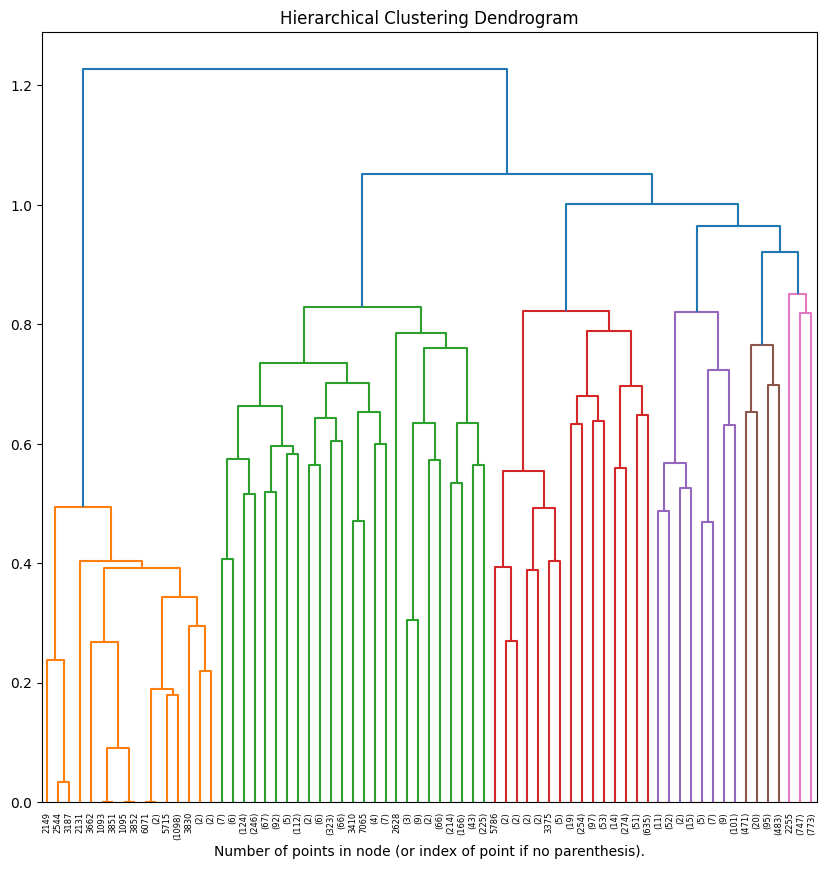

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


plt.figure(figsize=(10, 10))
plt.title("Hierarchical Clustering Dendrogram")
cluster_agg_dg = AgglomerativeClustering(n_clusters=None,
                                      distance_threshold=0,
                                      affinity='cosine',
                                      linkage='average')
cluster_agg_dg = cluster_agg_dg.fit(X)
plot_dendrogram(cluster_agg_dg, truncate_mode="level", p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
cluster_agg = AgglomerativeClustering(n_clusters=6,
                                      affinity='cosine',
                                      linkage='average')
cluster_agg = cluster_agg.fit(X)
DF_TO_CLUST["cluster_agg"] = cluster_agg.labels_
DF_TO_CLUST.cluster_agg.value_counts()

2    1798
0    1521
1    1412
3    1116
5    1069
4     202
Name: cluster_agg, dtype: int64

In [ ]:
for i in range(cluster_agg.n_clusters):
  sample_df = DF_TO_CLUST.loc[DF_TO_CLUST.cluster_agg == i]

  tfidf_vectorizer = TfidfVectorizer(max_features=312, tokenizer=tokenize_text)
  tfidf_matrix = tfidf_vectorizer.fit_transform(sample_df['overall_course_description_simple_preprocessing'])
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).mean()

  print(f"Cluster: {i}. Keywords: ", ', '.join(tfidf_df.nlargest(20).index.tolist()))
  display(sample_df.sample(5))
  print()

Cluster: 0. Keywords:  система, метод, данные, моделирование, модель, анализ, алгоритм, решение, математический, уравнение, обработка, обучение, сеть, основной, функция, процесс, теория, линейный, изображение, основа


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans,cluster_agg
10310,6308,master,3.0,6998,Радиочастотные системы и устройства,2020,Профильный профессиональный модуль,Численные методы в физике,В курсе излагаются основные принципы пост...,Подходы к построению численных методов\n\nСохр...,Численные методы в физике.\n\n\n\nВ курсе из...,численный метод физика излагаться основной при...,"[численный, метод, физика, излагаться, основно...","[численные методы, основные принципы, основные...","[0.211828283, -0.108499015, 0.59604024, -0.240...",9,0
27653,15092,master,14.0,7007,Речевые информационные системы,2020,"Специализация ""Биометрические информационные с...",Анализ акустических событий,В дисциплине изучаются методы анализа акустиче...,Извлечения признаков из аудио данных\n\nПробле...,Анализ акустических событий.\n\n\n\nВ дисципли...,анализ акустический событие дисциплина изучать...,"[анализ, акустический, событие, дисциплина, из...","[анализ акустических событий, методы анализа, ...","[-0.03516586, -0.0695822, 0.37181897, -0.62149...",8,0
35049,16022,bachelor,14.0,6974,Информатика и программирование,2020,Модуль обязательных дисциплин,Дополнительные главы дискретной математики,Дисциплина направлена на формирование математи...,Задача о потоке минимальной стоимости\n\nПоток...,Дополнительные главы дискретной математики.\n\...,дополнительный глава дискретный математика дис...,"[дополнительный, глава, дискретный, математика...","[дисциплина, формирование, привитие, развитие ...","[0.0423063828, -0.0662619098, 0.296355401, -0....",9,0
15250,10896,bachelor,13.0,6968,Технологии защиты информации,2021,"Специализация ""Системы надежной передачи инфор...",Вычислительная математика,В данном курсе студенты получат знания по элем...,Вводная часть.\n\nМесто вычислительной математ...,Вычислительная математика.\n\n\n\nВ данном кур...,вычислительный математика данный получать знан...,"[вычислительный, математика, данный, получать,...","[технологии искусственного интеллекта, место в...","[0.246576104, -0.145098149, 0.700366929, -0.25...",9,0
4479,3328,specialist,45.0,6907,Оптико-электронные информационно-измерительные...,2018,"Специализация ""Видеоинформационные системы""",Цифровой анализ изображений,В курсе рассмотрены классические методы и алго...,Цифровое изображение и пространственные методы...,Цифровой анализ изображений.\n\n\n\nВ курсе ра...,цифровой анализ изображение рассматривать клас...,"[цифровой, анализ, изображение, рассматривать,...","[анализ изображений, классические методы, алго...","[0.185298825, 0.0640221968, 0.44842365, -0.686...",8,0



Cluster: 1. Keywords:  управление, система, развитие, научный, метод, деятельность, информация, экологический, инновационный, основной, защита, безопасность, технология, анализ, организация, основа, предприятие, цифровой, процесс, средство


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans,cluster_agg
53286,22673,bachelor,22.0,6924,Цифровые системы управления,2019,Общеуниверситетские факультативы,Основы карьерного менеджмента,"Нет ни одного студента на земле, который не за...",Выстраиваем диалог с работодателем\n\nПодготов...,Основы карьерного менеджмента.\n\n\n\nНет ни о...,основа карьерный менеджмент земля задумываться...,"[основа, карьерный, менеджмент, земля, задумыв...","[основы карьерного менеджмента, профессиональн...","[-0.080190354, -0.0887650662, 0.118221467, -0....",0,1
18062,13076,master,44.0,7122,Стратегии и технологии цифровой трансформации,2021,"Специализация ""Фотоника индустрии 4.0""",Стандарты фотоники,Целью освоения дисциплины «Стандарты фотоники»...,Метрология и стандарты в области фотоники\n\nВ...,Стандарты фотоники.\n\n\n\nЦелью освоения дисц...,стандарт фотоника цель освоение дисциплина ста...,"[стандарт, фотоника, цель, освоение, дисциплин...","[стандарты, фотоники, изучение, основы, оптико...","[-0.24866456, -0.07876428, 0.35631767, -0.3528...",6,1
7843,4686,master,30.0,7045,Городское планирование и городской дизайн,2020,"Специализация ""Управление развитием города""",Общественные пространства и городская культура,Дисциплина «Общественные пространства и городс...,Исследование и диагностика общественных простр...,Общественные пространства и городская культура...,общественный пространство городской культура д...,"[общественный, пространство, городской, культу...","[городская культура, дисциплина, изучение, про...","[0.00253138, -0.08016257, 0.33639653, -0.22694...",10,1
9554,5271,master,14.0,7003,Программирование и искусственный интеллект,2020,Профильный профессиональный модуль,Управление проектами в информационных технологиях,Дисциплина направлена на получение знаний и на...,Проектная деятельность\n\nПроектная деятельнос...,Управление проектами в информационных технолог...,управление информационный технология дисциплин...,"[управление, информационный, технология, дисци...","[управление, дисциплина, получение знаний, про...","[-0.432382844, 0.156755734, 0.142216801, 0.021...",10,1
15265,10903,bachelor,1.0,6875,Управление технологическими инновациями,2018,Элективный модуль по группе направлений,Когнитивная экономика,В курсе будут рассмотрены вопросы теоретическо...,Модели поддержки принятия решений в сложных эк...,Когнитивная экономика.\n\n\n\nВ курсе будут ра...,когнитивный экономика рассматривать вопрос тео...,"[когнитивный, экономика, рассматривать, вопрос...","[когнитивная экономика, вопросы, применение, и...","[-0.141550928, 0.0530430397, 0.176294181, -0.2...",10,1



Cluster: 2. Keywords:  система, метод, оптический, основной, процесс, квантовый, материал, основа, технология, расчет, лазерный, свойство, энергия, устройство, анализ, уравнение, прибор, характеристика, принцип, теория


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans,cluster_agg
41974,20033,master,3.0,7258,Физика радиочастотных технологий,2022,Модуль специализации 3 - Технологии и системы ...,Телекоммуникационные системы,Курс направлен на формирование у студентов над...,Вопросы подготовки и реализации радиофизическо...,Телекоммуникационные системы.\n\n\n\nКурс напр...,телекоммуникационный система направлять формир...,"[телекоммуникационный, система, направлять, фо...","[формирование, электро радиоизмерений, слушате...","[-0.117597243, -0.126226443, 0.536603901, -0.5...",6,2
41429,19617,bachelor,3.0,7242,Робототехника и искусственный интеллект,2022,Продвинутый трек,Механика (продвинутый уровень),Курс предполагает собой интенсивное изучение о...,Физические основы механики\n\nСтруктура физики...,Механика (продвинутый уровень)\n\n\n\nКурс пре...,механика продвинутый уровень предполагать инте...,"[механика, продвинутый, уровень, предполагать,...","[механика, уровень, интенсивное изучение, изуч...","[-0.25299326, -0.26058287, 0.64770087, -0.0353...",2,2
6136,4232,bachelor,19.0,6871,Лазерные технологии,2018,"Специализация ""Лазерные технологии""",Лазерные технологии в медико-биологических исс...,"Дисциплина ""Лазерные технологии в медико-биоло...",Введение в биомедицину. Биологические молекулы...,Лазерные технологии в медико-биологических исс...,лазерный технология медикобиологический дисцип...,"[лазерный, технология, медикобиологический, ди...","[лазерные технологии, дисциплина, преподавание...","[-0.08838919, -0.2173191, 0.48571976, -0.22953...",7,2
40779,19530,bachelor,11.0,7241,Биотехнология,2022,Общепрофессиональный модуль,Современные достижения биотехнологии,Курс посвящен теме современных достижений биот...,Биологизация и экологизация\n\nСокращение вред...,Современные достижения биотехнологии.\n\n\n\nК...,современный достижение биотехнология посвящать...,"[современный, достижение, биотехнология, посвя...","[биотехнология, область знаний, промышленная о...","[-0.12972674, -0.25792953, 0.36764485, -0.0695...",7,2
6377,4367,bachelor,43.0,7311,Низкотемпературная техника и энергетика,2019,"Специализация ""Холодильная, криогенная техника...",Вакуумная техника,"В дисциплине рассматриваются, схемы вакуумных ...",Механические вакуумные насосы\n\nПоршневые нас...,Вакуумная техника.\n\n\n\nВ дисциплине рассмат...,вакуумный техника дисциплина рассматриваться с...,"[вакуумный, техника, дисциплина, рассматривать...","[механические вакуумные насосы, вакуумные насо...","[-0.14639559, -0.160165326, 0.424167124, -0.17...",6,2



Cluster: 3. Keywords:  systems, methods, research, optical, data, analysis, course, materials, design, quantum, management, control, students, development, basic, project, system, scientific, principles, information


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans,cluster_agg
17882,12933,master,1.0,6980,Инновационное предпринимательство / Innovation...,2021,"Специализация ""Предпринимательство в секторе И...",Стратегии управления интеллектуальной собствен...,"Within the discipline, the main strategies of ...",Features of legal support of activities in the...,Стратегии управления интеллектуальной собствен...,стратегия управление интеллектуальный собствен...,"[стратегия, управление, интеллектуальный, собс...","[икт, management strategy, ict within, main st...","[-0.0261331174, 0.225093307, 0.16691855, 0.059...",1,3
42086,20118,master,33.0,7261,Лазерные и синхротронные технологии мегасайенс...,2022,Обязательные дисциплины,Основы дифракционных методов структурной диагн...,You will get acquainted in detail with the met...,Analysis of diffraction data\n\nPowder diffrac...,Основы дифракционных методов структурной диагн...,основа дифракционный метод структурный диагнос...,"[основа, дифракционный, метод, структурный, ди...","[основы дифракционных методов, fundamentals, s...","[0.1041706, 0.10818793, 0.34423246, -0.0301636...",1,3
17530,12743,master,1.0,7076,Корпоративные финансы и венчурные инвестиции,2021,"Специализация ""Венчурное инвестирование / Vent...",Стартап и инновационное бизнес-моделирование /...,This course is intended for anyone who wants t...,14 directions: 7 directions on the value archi...,Стартап и инновационное бизнес-моделирование /...,стартап инновационный бизнесмоделирование star...,"[стартап, инновационный, бизнесмоделирование, ...","[create, interest, scale, looked, business mod...","[0.110579708, 0.249972995, 0.200269516, 0.0442...",1,3
39626,18623,master,42.0,7211,Индустриальная экология / Industrial ecology,2022,Интегрированный менеджмент / Integrated Manage...,Экологический менеджмент и аудит / Environment...,"In the classroom, students will learn about in...",Actions and processes in the environmental man...,Экологический менеджмент и аудит / Environment...,экологический менеджмент аудит environmental m...,"[экологический, менеджмент, аудит, environment...","[экологический менеджмент, environmental manag...","[-0.07097382, 0.27540548, 0.08455051, 0.079175...",1,3
41902,19896,master,32.0,7253,Прикладная оптика / Applied Optics,2022,Обязательные дисциплины (EN),Методы обработки изображений / Image Processing,"The course ""Image processing"" is devoted to me...","Basics of registration, modeling and digital o...",Методы обработки изображений / Image Processin...,метод обработка изображение image processing c...,"[метод, обработка, изображение, image, process...","[методы обработки, image processing, course im...","[0.20940139, 0.19989577, 0.37235603, -0.065167...",1,3



Cluster: 4. Keywords:  чертеж, создание, дизайн, деталь, моделирование, метод, трехмерный, основа, печать, анализ, построение, композиция, d, технология, система, модель, разработка, игровой, объект, изображение


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans,cluster_agg
41555,19644,bachelor,2.0,7286,Робототехника и искусственный интеллект,2022,Модуль обязательных профессиональных дисциплин,Компьютерная и инженерная графика,В рамках курса изучаются вопросы создания конс...,Компьютерная инженерная графика\n\nВинтовые по...,Компьютерная и инженерная графика.\n\n\n\nВ ра...,компьютерный инженерный график рамка изучаться...,"[компьютерный, инженерный, график, рамка, изуч...","[инженерная графика, вопросы создания, чертежи...","[-0.156643653, -0.0303678918, 0.534200442, -0....",6,4
41881,19869,master,15.0,7252,Цифровые методы в гуманитарных исследованиях /...,2022,Факультативные дисциплины,Онтология виртуального / Ontology of virtuality,Основная задача данного курса - познакомить с...,Гибель модерна\n\nВеликие открытия эпохи моде...,Онтология виртуального / Ontology of virtualit...,онтология виртуальный ontology virtuality осно...,"[онтология, виртуальный, ontology, virtuality,...","[ontology, virtuality, техно, кибер сферы, dig...","[0.0257704464, -0.142576461, 0.205787527, -0.1...",0,4
17058,12223,master,15.0,7116,"Анализ культурных данных и визуализация/ Data,...",2021,"Специализация ""Цифровая гуманитаристика""",Нарративный дизайн,Курс направлен на получение слушателем базовых...,"Выборы, конфликты и другие интерактивные элеме...",Нарративный дизайн.\n\n\n\nКурс направлен на п...,нарративный дизайн направлять получение слушат...,"[нарративный, дизайн, направлять, получение, с...","[нарративный дизайн, получение, теоретические ...","[-0.0334256961, -0.078570972, 0.465170164, -0....",0,4
22682,14930,All_levels,15.0,6859,Нанофотоника и квантовая оптика,2018,Факультативные дисциплины,Дизайн-мышление и креативные практики для запу...,Курс нацелен на выработку практических навыков...,Генерация идей\n\nПравила проведения брейнштор...,Дизайн-мышление и креативные практики для запу...,дизайнмышление креативный практик запуск нацел...,"[дизайнмышление, креативный, практик, запуск, ...","[дизайн, мышление, выработку практических навы...","[-0.0837972473, -0.0143528487, 0.284676085, -0...",0,4
49887,22660,All_levels,12.0,6924,Цифровые системы управления,2019,Общеуниверситетские факультативы,Основы блокчейн-технологий,Технологии распределенного реестра (они же тех...,DAO и токеномика проекта\n\nDAO и токеномика п...,Основы блокчейн-технологий.\n\n\n\nТехнологии ...,основа блокчейнтехнология технология распредел...,"[основа, блокчейнтехнология, технология, распр...","[блокчейн, технологии, nft, dao, введение, защ...","[0.12317224, -0.04026454, 0.18850329, -0.28147...",0,4



Cluster: 5. Keywords:  система, проектирование, программирование, управление, разработка, язык, программный, архитектура, технология, основа, информационный, данные, процесс, основной, средство, метод, сеть, принцип, обеспечение, тестирование


,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,cluster_kmeans,cluster_agg
9323,4962,master,1.0,6942,Управление качеством,2020,"Специализация ""Компьютерные системы управления...",Контроль качества программного обеспечения,"Дисциплина развивает знания, умения и навыки в...",Виды тестирования\n\nФункциональное и нефункци...,Контроль качества программного обеспечения.\n\...,контроль качество программный обеспечение дисц...,"[контроль, качество, программный, обеспечение,...","[контроль качества, дисциплина, навыки, виды т...","[-0.387546212, 0.217869266, 0.0555499371, -0.2...",3,5
4489,3342,specialist,44.0,6907,Оптико-электронные информационно-измерительные...,2018,"Специализация ""Оптико-электронные измерительны...",Методы и средства обработки данных систем спец...,В рамках дисциплины студент познакомится с при...,Аналого-цифровое преобразование видеосигнала. ...,Методы и средства обработки данных систем спец...,метод средство обработка данные система специа...,"[метод, средство, обработка, данные, система, ...","[средства обработки, цифровое преобразование, ...","[-0.12072931, 0.0578234, 0.4606272, -0.4652374...",6,5
28077,15334,bachelor,12.0,6895,Вычислительные системы и сети,2018,Модуль обязательных дисциплин,Основы профессиональной деятельности,В процессе изучения дисциплины студенты знаком...,Компоненты вычислительных систем\n\nВведение в...,Основы профессиональной деятельности.\n\n\n\nВ...,основа профессиональный деятельность процесс и...,"[основа, профессиональный, деятельность, проце...","[основы организации, эвм передачи, введение, о...","[-0.337728641, 0.241632126, 0.271395125, -0.57...",4,5
18144,13140,master,49.0,7033,Разработка программного обеспечения / Software...,2020,"Специализация ""Software Engineering""",Альтернативные языки для JVM,"Глубинное обучение - популярная область, в кот...",Введение. Знакомство с ОО парадигмой языка п...,Альтернативные языки для JVM.\n\n\n\nГлубинное...,альтернативный язык jvm глубинный обучение поп...,"[альтернативный, язык, jvm, глубинный, обучени...","[jvm, знакомство, scala, обзор, java, kotlin, ...","[0.00823482, -0.08274742, 0.40843697, -0.43228...",4,5
27947,15230,master,13.0,7155,Функциональная безопасность беспилотных трансп...,2021,"Специализация ""Эксплуатация безопасных беспило...",Системы управления на беспилотном транспорте,В рамках изучение данной дисциплины студенты п...,Аппаратные компоненты систем управления на бес...,Системы управления на беспилотном транспорте.\...,система управление беспилотный транспорт рамка...,"[система, управление, беспилотный, транспорт, ...","[изучение, аппаратные компоненты, аппаратные к...","[-0.150796802, 0.127890543, 0.476429825, -0.44...",3,5


*О чем (примерно) кластеры?*

*0. Математика + анализ данных*

*1. Экономика + инфобез*

*2. Физика + приборостроение*

*3. Англоязычные РПД*

*4. Дизайн*

*5. Программирование + проектирование и разработка*



*Последующие эксперименты не привожу, однако хочу отметить, что при увеличнии числа кластеров выделяются какие-то крохотные не особо когерентные кластеры, а те, которые по смысловому содержанию можно было бы разделить, так и остаются не разделенными.*

*TODO: хочется попробовать ТМ на данных, особенно [наш итмошный AutoTM](https://colab.research.google.com/drive/18Ac2-wBekhUH8iNKNX6GRXS8xSUqt0bz?usp=sharing).*

## Поиск "лишних" дисциплин

Эту часть выполните самостоятельно: постройте эмбеддинги для учебных планов по тому же принципу, по которому строили эмбеддинги для дисциплин. Затем проранжируйте все дисциплины в учебном плане по сходству с эмбеддингом плана. Выберите порог для значения сходства, ниже которого дисциплина считается "лишней".


Не нужно оценивать абсолютно все учебные планы из датасета. Можно выбрать около 10 случайных планов или тех, которые вам интересны. И оценить только их.

Обратите внимание, что типичнее для вашей выборки: малое или большое количество "лишних" дисциплин?

Проведите эксперимент: уберите из учебных планов все дисциплины, которые есть в каждом из них. Найдите "лишние" после удаления одинаковых. Оцените результат.

*Эмбеддинг учебного плана строится как усредненный вектор по всем векторам дисциплин, входящих в этот план.*

In [ ]:
temp = DF[['up_id', 'w2v_pr_tok_vector']].groupby('up_id').mean().reset_index()
temp.columns = ['up_id', 'up_mean_vector']

In [ ]:
UP_DF = pd.merge(DF, temp, on='up_id').drop_duplicates(['up_id', 'course_id']).sort_values(['up_id', 'start_year'])

*Посмотрим глазками на качество. Выглядит не очень.*

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


vector_cols = ['up_mean_vector']
ups_ids = [7081, 7162, 7247, 7340, 7022, 7342, 6876, 6919, 7123]  # первые три - ИТГС, дальше три Прикладной оптики и три Комп.технологий в дизайне
test_df = UP_DF[UP_DF.up_id.isin(ups_ids)].drop_duplicates(['up_id']).set_index('up_id')[vector_cols].reindex(ups_ids)


for vector_col in vector_cols:
    sample_test_df = pd.DataFrame(0, index=ups_ids, columns=ups_ids)
    for i in sample_test_df.index:
        for j in sample_test_df.columns:
            if i == j:
                sample_test_df.at[i, j] = np.nan
            else:
                sample_test_df.at[i, j] = cosine_similarity(test_df.loc[i][vector_col].reshape(1, -1),
                                                          test_df.loc[j][vector_col].reshape(1, -1))[0][0]
    sample_test_df = sample_test_df.style.background_gradient(cmap='Greens')
    print(vector_col)
    display(sample_test_df)
    print()

up_mean_vector


,7081,7162,7247,7340,7022,7342,6876,6919,7123
7081,nan,0.999739,0.998182,0.969356,0.819429,0.985380,0.988308,0.996789,0.997375
7162,0.999739,nan,0.998246,0.970910,0.819620,0.986703,0.988189,0.996750,0.997834
7247,0.998182,0.998246,nan,0.966645,0.822750,0.982683,0.988288,0.995659,0.995794
7340,0.969356,0.970910,0.966645,nan,0.839890,0.995632,0.974992,0.972634,0.974013
7022,0.819429,0.819620,0.822750,0.839890,nan,0.842555,0.810415,0.819029,0.825516
7342,0.985380,0.986703,0.982683,0.995632,0.842555,nan,0.981532,0.986938,0.989336
6876,0.988308,0.988189,0.988288,0.974992,0.810415,0.981532,nan,0.988725,0.986122
6919,0.996789,0.996750,0.995659,0.972634,0.819029,0.986938,0.988725,nan,0.998908
7123,0.997375,0.997834,0.995794,0.974013,0.825516,0.989336,0.986122,0.998908,nan


*Дальше будем экспериментировать со случайной выборкой учебных планов.*

In [ ]:
import random

random.seed(7)  # если поставить 1, то можно увидеть прекрасные учебные планы 2023г с 1-3 дисциплинами. интересно, от какого числа дамп.
RANDOM_UP_IDS = random.sample(UP_DF['up_id'].unique().tolist(), 10)
UP_DF[['up_id', 'up_title', 'start_year']][UP_DF['up_id'].isin(RANDOM_UP_IDS)].drop_duplicates()

,up_id,up_title,start_year
5920,6900,Управление в технических системах,2018
13668,6912,Прикладная и теоретическая физика,2020
7533,6925,Управление технологическими инновациями,2019
9673,6940,Интеллектуальные системы в гуманитарной сфере,2019
25693,6964,Цифровые системы управления,2021
36858,7025,Индустриальные киберфизические системы,2020
48347,7099,ФудТех / Foodtech,2021
60220,7222,Инновационный маркетинг,2022
61909,7265,Индустриальная биотехнология,2022
65697,7297,Инженерия машинного обучения,2022


In [ ]:
UP_DF[UP_DF['up_id'].isin(RANDOM_UP_IDS)].groupby('up_id')['course_id'].count().sort_values(ascending=False)

up_id
6964    239
6912    219
6925    180
6940    167
7099    133
6900    130
7222    120
7025    114
7297    111
7265     94
Name: course_id, dtype: int64

*В целом, выглядит неплохо, но факультативы и софт-скиллы существенно искажают картину.*



In [ ]:
THRESHOLD = 0.75  # методом тыка

for random_ip_id in RANDOM_UP_IDS:
    sample_up_df = UP_DF[UP_DF['up_id'] == random_ip_id]

    up_title = sample_up_df.iloc[0]['up_title']
    up_vector_mean = sample_up_df.iloc[0]['up_mean_vector'].reshape(1, -1)

    sample_up_df['cosine_similarity'] = sample_up_df['w2v_pr_tok_vector'].apply(
                lambda row: cosine_similarity(row.reshape(1, -1), up_vector_mean)[0][0])

    display(HTML(f"<b>{up_title}</b>"))
    display(sample_up_df[sample_up_df['cosine_similarity'] > THRESHOLD][['course_id', 'course_title', 'cosine_similarity']].sort_values('cosine_similarity', ascending=False))
    print()

,course_id,course_title,cosine_similarity
60294,21264,Как создать стартап. Курс от известных предпри...,0.964253
60242,14989,Управление карьерой,0.945468
60225,6878,Продвижение брендов,0.944559
60286,21221,Подбор персонала: от самопрезентации на собесе...,0.936793
60336,22703,Основы практического инвестирования,0.929996
...,...,...,...
60287,21224,Микроэкономика,0.794685
60312,22675,Основы разработки компьютерных игр в UE4 с пом...,0.791938
60298,22658,Основы экономики,0.790817
60318,22681,Экспериментальные методы клеточной биологии,0.779999


,course_id,course_title,cosine_similarity
36963,15939,FutureLifeStyle (FLS) 2.0 - технологические ре...,0.953223
36942,15441,Система синергетического развития ресурсов тел...,0.935865
36858,4620,Креативные технологии,0.926733
36925,14949,Геймификация процессов организации и управления,0.922054
36904,14926,Организация и управление бизнес-процессами,0.917584
...,...,...,...
36947,15922,Народ и власть в СССР,0.758465
36930,14955,Навигация по культуре Санкт-Петербурга,0.756694
36886,11095,Обработка и анализ данных,0.755907
36903,14925,Русский язык и культура речи,0.753859


,course_id,course_title,cosine_similarity
65756,22476,Сбор и обработка данных с помощью краудсорсинга,0.950412
65763,22492,Проектный семинар по инженерии машинного обучения,0.944229
65750,22466,Технологии обработки естественного языка,0.925707
65796,22690,Актуальные поэтические практики (креативное пи...,0.921590
65702,17528,Методология трансляционных исследований,0.915642
...,...,...,...
65706,17753,Продвинутое МО (Python) и Обработка изображений,0.783542
65793,22686,Автостопом по антиутопиям,0.780897
65758,22481,Технологии компьютерного зрения,0.775259
65709,17763,Введение в МО (Python) и Продвинутое МО (Python),0.775126


,course_id,course_title,cosine_similarity
13839,22689,Квантовая кибернетика,0.955129
13848,22700,Основы сексологии,0.923394
13873,25208,Вокальная и танцевальная импровизация,0.907068
13702,4035,Психология социальной адаптации и психосаморег...,0.905525
13810,22657,Организация и управление бизнес-процессами,0.901151
...,...,...,...
13678,2724,Хранение и обработка данных,0.752718
13715,4600,Статистическая физика,0.752658
13760,10946,Численные методы фотоники,0.752061
13741,9393,Численные методы физики,0.751145


,course_id,course_title,cosine_similarity
9761,14576,Практики креативности,0.948470
9799,22657,Организация и управление бизнес-процессами,0.932503
9680,2665,Технологии информационного поиска,0.931089
9819,22679,Практики креативности,0.925538
9719,4026,Техники публичных выступлений и презентаций,0.922914
...,...,...,...
9791,21225,Цели устойчивого развития в энергетике и ресур...,0.754605
9700,2843,Облачные технологии и услуги,0.753851
9706,2865,Математические методы машинного обучения,0.752378
9795,21233,Макроэкономика,0.751945


,course_id,course_title,cosine_similarity
25888,22689,Квантовая кибернетика,0.943623
25814,14576,Практики креативности,0.920521
25897,22700,Основы сексологии,0.904307
25915,25208,Вокальная и танцевальная импровизация,0.900471
25885,22685,Сложная коммуникация,0.900449
...,...,...,...
25755,10285,Теория вероятностей,0.761001
25883,22683,Дизайн в культуре,0.760480
25820,14845,Программирование,0.757240
25788,10617,Машинное обучение,0.756724


,course_id,course_title,cosine_similarity
61911,14989,Управление карьерой,0.938039
61921,17515,Основы концептуального мышления,0.935604
61979,22679,Практики креативности,0.934758
61916,17490,Мышление и научная рациональность,0.930152
61989,22690,Актуальные поэтические практики (креативное пи...,0.927845
...,...,...,...
61975,22675,Основы разработки компьютерных игр в UE4 с пом...,0.793216
61969,22668,Введение в вычислительное музыковедение,0.790485
61912,15930,Вокальная и танцевальная импровизация,0.779864
61984,22684,Биохимия: основная теория и методология,0.757843


,course_id,course_title,cosine_similarity
7670,22657,Организация и управление бизнес-процессами,0.953967
7617,10333,Инновационная экономика и технологическое пред...,0.947568
7690,22679,Практики креативности,0.946040
7660,21221,Подбор персонала: от самопрезентации на собесе...,0.942475
7633,14576,Практики креативности,0.939912
...,...,...,...
7545,2670,Обработка сигналов,0.760131
7534,2640,Теория автоматического управления,0.758878
7541,2662,Иностранный язык в профессиональной деятельности,0.754985
7549,2724,Хранение и обработка данных,0.754286


,course_id,course_title,cosine_similarity
48456,22679,Практики креативности,0.892577
48383,12804,Опыт пользователя и инновационные подходы в ра...,0.891510
48394,12815,Биоэтика пищевых биотехнологий,0.889918
48427,21221,Подбор персонала: от самопрезентации на собесе...,0.889711
48348,4621,Создание технологического бизнеса,0.889141
...,...,...,...
48366,11554,Процессы и аппараты пищевых производств,0.769715
48411,14574,Мышление (Визуальные формы мышления и кинемато...,0.763591
48461,22684,Биохимия: основная теория и методология,0.761999
48449,22671,Теория игр,0.756223


,course_id,course_title,cosine_similarity
6010,15441,Система синергетического развития ресурсов тел...,0.968009
6035,15939,FutureLifeStyle (FLS) 2.0 - технологические ре...,0.943998
5971,14926,Организация и управление бизнес-процессами,0.920566
5992,14949,Геймификация процессов организации и управления,0.914929
5921,2637,"Техники публичных выступлений, переговоров и п...",0.912216
...,...,...,...
5942,3466,Автоматизированные информационно-управляющие с...,0.764704
5957,7541,Науки о жизни,0.764495
6048,16004,Методы криптографии,0.763460
5966,14838,Техника и физика низких температур,0.760061


*Выбросим из данных мусорные для нашей задачи дисциплины, а именно факультативы и софт-скиллы. Ничего не имею против данных дисциплин, но как будто бы они не про предметы, а про надпрофессиональные компетенции.*

In [ ]:
throwaway = (UP_DF['module_name'][UP_DF['module_name'].str.contains('Soft Skills', case=False)].unique().tolist() +
             UP_DF['module_name'][UP_DF['module_name'].str.contains('Факультатив', case=False)].unique().tolist() +
             UP_DF['module_name'][UP_DF['module_name'].str.contains('Иностранный язык', case=False)].unique().tolist() +
             UP_DF['module_name'][UP_DF['module_name'].str.contains('Философия', case=False)].unique().tolist() +
             UP_DF['module_name'][UP_DF['module_name'].str.contains('История', case=False)].unique().tolist()
             )

DF_TRUNC = DF[~DF['module_name'].isin(throwaway)]

In [ ]:
temp = DF_TRUNC[['up_id', 'w2v_pr_tok_vector']].groupby('up_id').mean().reset_index()
temp.columns = ['up_id', 'up_mean_vector']

In [ ]:
UP_DF_TRUNC = pd.merge(DF_TRUNC, temp, on='up_id').drop_duplicates(['up_id', 'course_id']).sort_values(['up_id', 'start_year'])

*Также выбросим предметы, которые встречаются во всех учебных планах нашей выборки.*

In [ ]:
SAMPLE_DF = UP_DF_TRUNC[UP_DF_TRUNC['up_id'].isin(RANDOM_UP_IDS)]

sets = []
for up_id in SAMPLE_DF['up_id'].unique():
    sets.append(set(SAMPLE_DF[SAMPLE_DF['up_id'] == up_id]['course_title']))  # можно ориентироваться на course_id, а не на course_title

result_intersection_loop = sets[0]
for s in sets[1:]:
    result_intersection_loop &= s

SAMPLE_DF = SAMPLE_DF[~SAMPLE_DF['course_title'].isin(list(result_intersection_loop))]  # под нашу выборку тут пусто, но код рабочий

In [ ]:
THRESHOLD = 0.8  # методом тыка

for random_ip_id in RANDOM_UP_IDS:
    sample_up_df = SAMPLE_DF[SAMPLE_DF['up_id'] == random_ip_id]

    up_title = sample_up_df.iloc[0]['up_title']
    up_vector_mean = sample_up_df.iloc[0]['up_mean_vector'].reshape(1, -1)

    sample_up_df['cosine_similarity'] = sample_up_df['w2v_pr_tok_vector'].apply(
                lambda row: cosine_similarity(row.reshape(1, -1), up_vector_mean)[0][0])

    display(HTML(f"<b>{up_title}</b>"))
    display(sample_up_df[sample_up_df['cosine_similarity'] > THRESHOLD][['course_id', 'course_title', 'cosine_similarity']].sort_values('cosine_similarity', ascending=False))
    print()

,course_id,course_title,cosine_similarity
22876,21264,Как создать стартап. Курс от известных предпри...,0.959476
22834,6878,Продвижение брендов,0.943887
22862,18880,Digital-коммуникации,0.933823
22836,6880,Digital-аналитика,0.932284
22837,6882,Инструменты digital-маркетинга,0.932167
22852,17498,Создание технологического бизнеса,0.923571
22873,20470,Создание технологического бизнеса,0.921803
22842,12187,"Маркетинг, позиционирование, бренд",0.918986
22866,18884,Маркетинговая поддержка инновационных проектов,0.916154
22831,6838,Стратегический маркетинг в секторе Cleantech,0.915712


,course_id,course_title,cosine_similarity
14339,4878,Новые производственные технологии,0.946353
14352,11354,Проектирование систем технологической подготов...,0.939361
14349,6161,Реинжиниринг процессов проектирования и произв...,0.924123
14342,6149,Производственные киберфизические системы,0.919806
14359,12294,Киберфизические системы и технологии,0.906143
14343,6154,Компьютерное моделирование технологических и п...,0.902763
14344,6155,Информационная поддержка производственных этап...,0.899117
14353,11356,Информационная поддержка жизненного цикла изделий,0.898461
14354,11357,Моделирование производственных процессов,0.896749
14345,6156,Системы управления технологическим оборудованием,0.871520


,course_id,course_title,cosine_similarity
25987,22476,Сбор и обработка данных с помощью краудсорсинга,0.940623
25994,22492,Проектный семинар по инженерии машинного обучения,0.928633
25984,22470,Разработка интеллектуальных систем на языке Py...,0.926369
25985,22471,Введение в инженерию машинного обучения,0.925388
25981,22466,Технологии обработки естественного языка,0.923775
25949,17760,Автоматическая обработка текстов и Социальные ...,0.923232
25953,17764,Продвинутое МО (Python) и Автоматическая обраб...,0.921133
25980,22465,Разработка приложений разговорного искусственн...,0.920489
25945,17528,Методология трансляционных исследований,0.917604
25990,22482,Глубокое обучение и компьютерное зрение,0.893046


,course_id,course_title,cosine_similarity
4922,7666,Теория фазовых переходов,0.910791
4914,7292,Теория массового обслуживания,0.907082
4950,14853,Астрофизика,0.896362
4905,4601,Теория групп,0.895901
4867,2640,Теория автоматического управления,0.895452
4883,3151,Теоретическая и прикладная механика,0.890282
4953,15173,Дополнительные главы статистической физики,0.869423
4928,9770,Нелинейная физика,0.867101
4931,9772,Распространение и прием радиоволн,0.863124
4903,4596,Квантовая механика,0.856835


,course_id,course_title,cosine_similarity
4614,2665,Технологии информационного поиска,0.948842
4642,4000,Системы искусственного интеллекта,0.932988
4677,15711,Инженерия знаний,0.930249
4645,4009,Учебная аналитика,0.913311
4680,16067,Технологии информационного поиска,0.910744
4651,4510,Технологии информационного поиска,0.910744
4666,10931,Математическая лингвистика,0.907235
4619,2672,Анализ социальных сетей,0.906740
4649,4013,Анализ социальных сетей,0.904558
4659,8285,Управление проектами,0.897483


,course_id,course_title,cosine_similarity
10949,7292,Теория массового обслуживания,0.940595
10943,4331,Математические основы теории систем,0.934143
11004,10667,Принципы построения приборов ориентации,0.930698
11014,15213,Введение в профессиональную деятельность,0.923578
11005,10668,Инерциальные и интегрированные навигационные с...,0.908570
11002,10665,Спутниковые навигационные системы,0.900620
11006,10681,Теория идентификации,0.892946
10999,10662,Испытание навигационных систем и программы обр...,0.891796
11015,15395,Компьютерное управление мехатронными системами,0.889345
10998,10661,Математические основы теории оценивания,0.888712


,course_id,course_title,cosine_similarity
25347,22211,Современные достижения промышленной биотехнологии,0.903553
25344,22193,Разработка и культивирование продуцентов реком...,0.874592
25334,17510,Этика науки и технологий,0.872062
25355,22248,Аналитические инструменты опытного исследователя,0.872016
25331,17490,Мышление и научная рациональность,0.865047
25354,22245,"Разработка, производство и дистрибуция лекарст...",0.860246
25335,17515,Основы концептуального мышления,0.854549
25352,22220,"Создание, внедрение и продвижение новых технол...",0.852473
25342,22190,Биотехнология растений,0.850215
25341,22185,Научная литература и нормативная документация,0.831013


,course_id,course_title,cosine_similarity
3727,16099,Технология нововведений,0.961371
3718,10903,Когнитивная экономика,0.959686
3716,10333,Инновационная экономика и технологическое пред...,0.944990
3680,3877,Инфраструктура и ресурсное обеспечение цифрово...,0.944084
3683,3885,Коммерциализация инноваций,0.942992
...,...,...,...
3709,7262,Методы искусственного интеллекта,0.816412
3711,7292,Теория массового обслуживания,0.812367
3719,10906,Экология,0.810614
3710,7273,Компьютерная безопасность,0.801466


,course_id,course_title,cosine_similarity
18365,12840,Прикладной ФудТех,0.890519
18347,12798,Биотехнология функциональных и специализирован...,0.889540
18351,12803,Инновационные технологии в разработке продукто...,0.887919
18338,11555,Технологии разработки продуктов питания,0.885044
18357,12809,Идентификация фальсификации пищевого сырья и п...,0.882933
18371,12846,Пищевая инженерия и технология,0.880824
18348,12799,Детское питание и питание детей раннего возраста,0.877448
18356,12808,Инновационные технологии производства экологич...,0.876263
18361,12813,Продуктивность и оптимизация ресурсов в произв...,0.870063
18374,14471,Прикладные методы в разработке продуктов питания,0.869732


,course_id,course_title,cosine_similarity
9002,7444,Теория массового обслуживания,0.923745
8990,3839,Микроконтроллерная техника систем управления,0.895937
8988,3442,Прикладная теория информации,0.894604
9001,7290,Методы информационного поиска,0.888559
8991,3840,Преобразователи информации систем управления,0.884773
8985,3063,Дизайн вещей будущего,0.882870
9019,16157,Технические средства автоматизации и управления,0.881846
9009,13977,Основы научно-технического творчества,0.872883
8973,2642,Методы и средства программного обеспечения,0.871450
9007,10302,"Планирование эксперимента, методы анализа и об...",0.867709


*Хочется также настроить возможность поиска ближайших учебных планов.*

In [ ]:
UP_DF_TRUNC_FOR_SIM = UP_DF_TRUNC.drop_duplicates('up_id')

In [ ]:
%%capture
!pip install faiss-cpu

In [ ]:
import faiss


EMBEDDINGS = np.vstack(UP_DF_TRUNC_FOR_SIM['up_mean_vector'])
INDEX = faiss.IndexFlatIP(EMBEDDINGS.shape[1])
INDEX.add(EMBEDDINGS.astype(np.float32))


def get_k_closests_ups(up_id, k):
    try:
        query_vector = UP_DF_TRUNC_FOR_SIM[UP_DF_TRUNC_FOR_SIM['up_id'] == up_id]['up_mean_vector'].values[0]
        query_vector /= np.linalg.norm(query_vector)
        similarities, neighbors = INDEX.search(np.array([query_vector], dtype=np.float32), k)  # с фаисом такая история, что все значения относительные, поэтому threshold ставить бессмысленно
        neighbors = neighbors[0]
        return UP_DF_TRUNC_FOR_SIM.iloc[neighbors]
    except IndexError:
        return None

*Выглядит вполне правдоподобно.*

In [ ]:
UP_DF_TRUNC_FOR_SIM[UP_DF_TRUNC_FOR_SIM['up_id'] == 6940]

,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,up_mean_vector
4609,2640,bachelor,2.0,6940,Интеллектуальные системы в гуманитарной сфере,2019,ОГНП 2: Киберфизические системы и технологи,Теория автоматического управления,"Дисциплина охватывает круг вопросов, связанных...",Временные характеристики (программа онлайн-кур...,Теория автоматического управления.\n\n\n\nДисц...,теория автоматический управление дисциплина ох...,"[теория, автоматический, управление, дисциплин...","[теория автоматического управления, дисциплина...","[-0.0622139449, 0.0912072839, 0.43690846, -0.2...","[-0.014510398879636224, 0.007467024022237427, ..."


In [ ]:
get_k_closests_ups(6940, 5)

,course_id,qualification,unit_id,up_id,up_title,start_year,module_name,course_title,description,section_topic,overall_course_description,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,section_topic_terms,w2v_pr_tok_vector,up_mean_vector
26102,23940,master,51.0,7462,Математические технологии системного анализа,2023,Профессиональная подготовка,Технологии математического моделирования,Дисциплина направлена на формирование навыков ...,Технологии математического моделирования\n\nМо...,Технологии математического моделирования.\n\n\...,технология математический моделирование дисцип...,"[технология, математический, моделирование, ди...","[технологии математического моделирования, дис...","[0.32722694, 0.02159127, 0.57208509, -0.479729...","[0.047899207535555564, 0.04759814636666667, 0...."
24513,16287,master,12.0,7170,Компьютерные системы и технологии,2021,Модуль обязательных дисциплин,Организация вычислительного процесса / Computa...,Дисциплина охватывает следующий круг вопросов:...,Введение. Определение вычислительного процесса...,Организация вычислительного процесса / Computa...,организация вычислительный процесс computation...,"[организация, вычислительный, процесс, computa...","[определение вычислительного процесса, методы ...","[-0.06688487, 0.10162524, 0.63843809, -0.27755...","[-0.06688487, 0.10162524, 0.63843809, -0.27755..."
21463,5352,master,12.0,7084,Компьютерные системы и технологии,2020,Профильный профессиональный модуль,Организация вычислительного процесса / Computa...,Дисциплина охватывает следующий круг вопросов:...,Введение. Определение вычислительного процесса...,Организация вычислительного процесса / Computa...,организация вычислительный процесс computation...,"[организация, вычислительный, процесс, computa...","[определение вычислительного процесса, методы ...","[-0.06688487, 0.10162524, 0.63843809, -0.27755...","[-0.06688487, 0.10162524, 0.63843809, -0.27755..."
3018,2640,bachelor,2.0,6910,Бизнес-информатика,2019,ОГНП 2: Киберфизические системы и технологи,Теория автоматического управления,"Дисциплина охватывает круг вопросов, связанных...",Временные характеристики (программа онлайн-кур...,Теория автоматического управления.\n\n\n\nДисц...,теория автоматический управление дисциплина ох...,"[теория, автоматический, управление, дисциплин...","[теория автоматического управления, дисциплина...","[-0.0622139449, 0.0912072839, 0.43690846, -0.2...","[-0.123032735808, -0.005121418805624998, 0.267..."
13557,3856,bachelor,1.0,7244,Бизнес-информатика,2022,Общая профессиональная подготовка,Системный анализ и принятие решений,В курсе будут рассмотрены основные понятия сис...,Основы системного анализа\n\nДекомпозиция и аг...,Системный анализ и принятие решений.\n\n\n\nВ ...,системный анализ принятие решение рассматриват...,"[системный, анализ, принятие, решение, рассмат...","[системный анализ, принятие решений, основы си...","[0.101528064, -0.12966353, 0.365440005, -0.240...","[-0.10552224839361111, 0.01982553302680556, 0...."


## Генерация содержания

В этой части работы вам предлагается повторить пайплайн дообучения модели [LLaMA](https://github.com/facebookresearch/llama) (LLM с открытым исходным кодом) из туториала: https://colab.research.google.com/drive/1tG9eqttfnqHoQqmsiacywUG9ilUhoiCk?usp=sharing#scrollTo=qL5i358PRGgu

С текстовым описанием: https://www.datacamp.com/tutorial/fine-tuning-llama-2

Обзор с Хабра: https://habr.com/ru/articles/755114/

Если памяти или ресурсов колаба не хватит, то попробуйте без дообучения. Но результат будет хуже.

Выберите 10-15 дисциплин (случайных или интересных вам) и с помощью модели сгенерируйте возможное описание дисциплины.

Постройте эмбеддинг для полученного описания. Оцените близость полученного эмбеддинга и того, что у вас уже был с момента создания word2vec.

Среди выбранных вами дисциплин найдите те, которые реализуются больше одного года. Изучите их следующим образом:

1. Оцените, насколько содержательно близки дисциплины разных лет.
2. Оцените, к дисциплине какого года ближе всего сгенерированное содержание.

*В данной работе мы попробовали две разных модели - Ламу и Мистраль.*

### Llama-7B

*Процесс дообучения модели можно найти в [колабе по ссылке](https://colab.research.google.com/drive/1irLo_ANLHsnBovCsrXXUuyYL8poF_GHk?usp=sharing).*

### Mistral-7B

*А если точнее, то [dolphin-2.0-mistral-7b](https://huggingface.co/ehartford/dolphin-2.0-mistral-7b). Ресурсов колаба не хватает, поэтому всю работу выполняем в [kaggle](https://www.kaggle.com/sonyanik/itmo-edu).*

*Как показало изучение материалов по fine-tuning-у моделей, данные стоит готовить несколько в другом формате, нежели в том, который мы создали до этого. Формат, в котором хочется видеть данные:*

*Дисциплина: <название дисциплины>*

*Описание: <описание дисциплины в одну строку>*

*Раздел 1: <соответствующий раздел>*

*Тема 1.1: <соответствующая тема>*

*Тема 1.2: <соответствующая тема>*

*...*

In [43]:
def add_period(text):
  if len(text) > 2 and text[-1] not in ".!? ":
    text += '.'
  return text


grouped_df =  DF[['course_id', 'course_title', 'description', 'section', 'topic']].drop_duplicates().groupby('course_id')
prompts = []
rpds = []

for course_id, group in grouped_df:
    temp_info = ""
    discipline = group['course_title'].iloc[0]
    temp_info += add_period(f"Дисциплина: {discipline}") + '\n'
    description = group['description'].iloc[0]
    temp_info += re.sub(r'\s+', ' ', add_period(f"Описание: {description}")).strip() + '\n'

    section_grouped = group.groupby('section')
    for section_num, (section, section_group) in enumerate(section_grouped, start=1):
        temp_info += add_period(f"Раздел {section_num}: {section}") + '\n'

        topic_grouped = section_group.groupby('topic')
        for topic_num, (topic, topic_group) in enumerate(topic_grouped, start=1):
            temp_info += add_period(f"Тема {section_num}.{topic_num}: {topic}") + '\n'

    prompts.append(f'Напиши описание и тематическую структуру курса по дисциплине "{discipline}". Тематическая структура должна состоять из разделов и тем.')
    rpds.append(temp_info.strip())

In [44]:
print(rpds[10])  # sample

Дисциплина: Современные инструменты анализа данных.
Описание: Дисциплина представлена 4 разделами, раскрывающими ключевые области инфокоммуникационных технологий: 1. Разведочный анализ данных: методы, инструменты, ошибки, о которых надо знать 2. Кластерный анализ и анализ текстовых данных 3. Сетевое взаимодействие и сервисы для обработки данных 4. Базовые функции Python За каждым разделом закреплен преподаватель – специалист в соответствующей области. Разделы можно изучать в произвольном порядке. Каждый раздел состоит из 2 лекций и 4 практических занятий. Выполненные на занятиях работы засчитываются при рубежной аттестации и являются основой для накопления баллов, необходимых для получения зачета. В процессе изучения дисциплины студенты узнают о том, что такое Big Data, Data Science, Python, BI-технологии и аналитика данных, приобретут навыки создания систем хранения и обработки больших объемов данных.
Раздел 1: Базовые функции Python.
Тема 1.1: Базовые приемы визуализации данных.
Тема

In [46]:
data_for_training = pd.DataFrame({'input': prompts, 'output': rpds})
data_for_training['input'] = '<s>[INST] ' + data_for_training['input'] + ' [/INST] '
data_for_training = pd.DataFrame(data_for_training['input'] + data_for_training['output'] + '</s>', columns=['text'])
data_for_training.head()

,text
0,<s>[INST] Напиши описание и тематическую струк...
1,<s>[INST] Напиши описание и тематическую струк...
2,<s>[INST] Напиши описание и тематическую струк...
3,<s>[INST] Напиши описание и тематическую струк...
4,<s>[INST] Напиши описание и тематическую струк...


In [47]:
data_for_training['text'].map(len).describe()  # to understand what to do with max_length

count     7118.000000
mean      2190.326215
std       1447.903732
min        276.000000
25%       1379.000000
50%       1881.000000
75%       2584.000000
max      29409.000000
Name: text, dtype: float64

In [63]:
filtered_data = data_for_training[data_for_training['text'].apply(lambda t: len(t) < 2500)].reset_index(drop=True)
len(filtered_data)

5160

In [14]:
!pip install -q datasets
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: w

In [64]:
import datasets
from datasets import Dataset, DatasetDict

training_dataset = Dataset.from_pandas(filtered_data)
training_dataset

Dataset({
    features: ['text'],
    num_rows: 5160
})

In [65]:
training_dataset.push_to_hub("sonyaleaf/itmo-edu-gen-rpds")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

*Сделаем также меньшую версию датасета, потому что по оценкам trainer-а, полный датасет займет ~15 часов, а максимальная длина сессии в kaggle равна 12 часам.*

In [68]:
smaller_training_dataset = Dataset.from_pandas(filtered_data.sample(1000, random_state=42))

In [69]:
smaller_training_dataset.push_to_hub("sonyaleaf/itmo-edu-gen-rpds-1k")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

*Оба данных датасета находятся на huggingface.*

*TODO: разобраться, какую лицензию необходимо указать, чтобы использовать датасет можно было только с моего разрешения.*

### Результаты

*На текущий момент приведены резульаты для дообученной Ламы и для Мистрали из коробки. Причина - дообученная Мистраль работает очень долго и сильно галлюцинирует. Пример:*

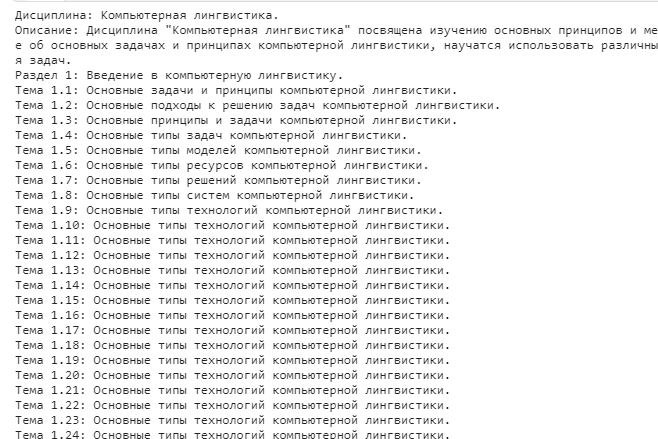

In [63]:
disciplines = ["Компьютерная лингвистика", "Креативные технологии", "Программирование Python",
               "Теория автоматического управления", "Экология", "Общая физика", "Управление брендами",
               "Управление технологическим продуктом", "Информатика", "Биохимия"]

SMALLER_DF = DF[DF['course_title'].isin(disciplines)][['course_id', 'course_title',
                                                       'start_year', 'overall_course_description',
                                                       'section_topic_terms',	'w2v_pr_tok_vector']].drop_duplicates(['course_title',
                                                                                                                    'start_year', 'overall_course_description'])

In [70]:
LLAMA_RES = pd.read_csv(PATH + 'data/llama-finetuned-generated.csv')
LLAMA_RES['overall_course_description_simple_preprocessing'] = LLAMA_RES['text'].apply(simple_preprocessing)
LLAMA_RES['overall_course_description_simple_preprocessing_tokenized'] = LLAMA_RES['overall_course_description_simple_preprocessing'].apply(tokenize_text)
LLAMA_RES['w2v_pr_tok_vector'] = LLAMA_RES['overall_course_description_simple_preprocessing_tokenized'].apply(lambda tokens: embed(tokens, W2V_PR_TOK))
LLAMA_RES['section_topic_terms'] = LLAMA_RES['text'].apply(get_terms)
LLAMA_RES

,course_title,text,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,w2v_pr_tok_vector,section_topic_terms
0,Компьютерная лингвистика,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина ком...,"[описание, тематический, структура, дисциплина...","[-0.5782242796681437, -0.38244594821283956, 0....","[описание, тематическая структура, компьютерна..."
1,Креативные технологии,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина кре...,"[описание, тематический, структура, дисциплина...","[-0.6985740494921462, -0.4680997451525608, -0....","[технологии, инновационные продукты, сервисы]"
2,Программирование Python,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина про...,"[описание, тематический, структура, дисциплина...","[-0.3546813216544078, -0.3341597140500588, 0.4...","[описание, тематическая структура, программиро..."
3,Теория автоматического управления,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина тео...,"[описание, тематический, структура, дисциплина...","[-0.032632941071262314, -0.24625800845760795, ...","[описание, тематическая структура, теория авто..."
4,Экология,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина эко...,"[описание, тематический, структура, дисциплина...","[0.22570787297923173, 0.3841829780322402, 0.53...","[описание, тематическая структура, наука, осно..."
5,Общая физика,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина общ...,"[описание, тематический, структура, дисциплина...","[0.6011743871879972, -0.09757374366360509, -0....","[описание, тематическая структура, методы, зак..."
6,Управление брендами,Управление брендами / Brand Management\n\nОпис...,управление бренд brand management описание дан...,"[управление, бренд, brand, management, описани...","[-0.2931745403095499, 0.3872098457431058, -0.2...","[управление, brand management, market, events]"
7,Управление технологическим продуктом,Управление технологическим продуктом / Technic...,управление технологический продукт technical p...,"[управление, технологический, продукт, technic...","[0.37210437705119453, -0.303946817236849, 0.01...","[управление, technical product, technical prod..."
8,Информатика,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина инф...,"[описание, тематический, структура, дисциплина...","[-1.0166000890908458, -0.42310976745132267, 0....","[описание, тематическая структура, информатика..."
9,Биохимия,Описание и тематическая структура курса по дис...,описание тематический структура дисциплина био...,"[описание, тематический, структура, дисциплина...","[0.6033247076991669, -0.132874785566613, -0.07...","[описание, тематическая структура, biochemistr..."


In [75]:
MISTRAL_RES = pd.read_csv(PATH + 'data/dolphin-from-box-generated.csv', sep=';')
MISTRAL_RES['overall_course_description_simple_preprocessing'] = MISTRAL_RES['text'].apply(simple_preprocessing)
MISTRAL_RES['overall_course_description_simple_preprocessing_tokenized'] = MISTRAL_RES['overall_course_description_simple_preprocessing'].apply(tokenize_text)
MISTRAL_RES['w2v_pr_tok_vector'] = MISTRAL_RES['overall_course_description_simple_preprocessing_tokenized'].apply(lambda tokens: embed(tokens, W2V_PR_TOK))
MISTRAL_RES['section_topic_terms'] = MISTRAL_RES['text'].apply(get_terms)
MISTRAL_RES

,course_title,text,overall_course_description_simple_preprocessing,overall_course_description_simple_preprocessing_tokenized,w2v_pr_tok_vector,section_topic_terms
0,Компьютерная лингвистика,"Описание курса по дисциплине ""Компьютерная лин...",описание дисциплина компьютерный лингвистика к...,"[описание, дисциплина, компьютерный, лингвисти...","[-1.3521713747116797, -0.5367602153693314, 0.2...","[описание, компьютерная лингвистика, изучение ..."
1,Креативные технологии,"Описание курса по дисциплине ""Креативные техно...",описание дисциплина креативный технология креа...,"[описание, дисциплина, креативный, технология,...","[-0.5861388786624258, -0.35012602621953615, 0....","[описание, креативные технологии, изучение раз..."
2,Программирование Python,"Описание курса по дисциплине ""Программирование...",описание дисциплина программирование python пр...,"[описание, дисциплина, программирование, pytho...","[-1.5399846210765342, -0.3558666482451372, 1.2...","[python, программирование, основы, установка, ..."
3,Теория автоматического управления,Описание курса по Теории автоматического управ...,описание теория автоматический управление теор...,"[описание, теория, автоматический, управление,...","[0.22011246677406282, 0.07231369333316547, 0.3...","[depth, теория управления, теория систем, serv..."
4,Экология,"Описание курса по дисциплине ""Экология"":\n\nКу...",описание дисциплина экология экология предлага...,"[описание, дисциплина, экология, экология, пре...","[-0.377701357209889, 0.44897986203432083, 0.50...",[экология]
5,Общая физика,"Описание курса по дисциплине ""Общая физика"":\n...",описание дисциплина общий физика общий физика ...,"[описание, дисциплина, общий, физика, общий, ф...","[0.3800540978034723, 0.26122493316753975, -0.1...","[описание, общая физика, дисциплина, аспекты ф..."
6,Управление брендами,"Описание курса по дисциплине ""Управление бренд...",описание дисциплина управление бренд описание ...,"[описание, дисциплина, управление, бренд, опис...","[-0.545321259157438, 0.06229775534174813, 0.36...","[описание, управление, основы, различные аспек..."
7,Управление технологическим продуктом,"Описание курса ""Управление технологическим про...",описание управление технологический продукт уп...,"[описание, управление, технологический, продук...","[0.29295473566063407, 0.15505583075882526, 0.0...","[управление, высокий уровень, высокий уровень ..."
8,Информатика,"Описание курса по дисциплине ""Информатика"":\n\...",описание дисциплина информатика информатика пр...,"[описание, дисциплина, информатика, информатик...","[-0.38018666509508103, -0.09086001513541238, 0...",[теория программирования]
9,Биохимия,"Описание курса по дисциплине ""Биохимия"":\n\nКу...",описание дисциплина биохимия биохимия предлага...,"[описание, дисциплина, биохимия, биохимия, пре...","[-0.07082150263122196, 0.07958699037863624, 0....","[описание, depth, основные законы, основные за..."


In [65]:
for discipline in disciplines:
    display(HTML(f"<b>{discipline}</b>"))
    selected_df = SMALLER_DF[SMALLER_DF['course_title'] == discipline]
    selected_llama = LLAMA_RES[LLAMA_RES['course_title'] == discipline]
    selected_mistral = MISTRAL_RES[MISTRAL_RES['course_title'] == discipline]

    for _, row in selected_df.iterrows():
        print(f"start_year: {row['start_year']}")

        csl = cosine_similarity(row['w2v_pr_tok_vector'].reshape(1, -1), selected_llama['w2v_pr_tok_vector'].values[0].reshape(1, -1))[0][0]
        csm = cosine_similarity(row['w2v_pr_tok_vector'].reshape(1, -1), selected_mistral['w2v_pr_tok_vector'].values[0].reshape(1, -1))[0][0]
        print(f"Cosine sim llama: {csl}, cosine sim mistral: {csm}.")

        jsl = jaccard_similarity(row['section_topic_terms'], selected_llama['section_topic_terms'].values[0])
        jsm = jaccard_similarity(row['section_topic_terms'], selected_mistral['section_topic_terms'].values[0])
        print(f"Jaccard sim llama: {jsl}, Jaccard sim mistral: {jsm}.")

        print()

start_year: 2018
Cosine sim llama: -0.0238890097139948, cosine sim mistral: -0.061605302674500276.
Jaccard sim llama: 0.08333333333333333, Jaccard sim mistral: 0.02631578947368421.

start_year: 2019
Cosine sim llama: -0.016013324358196662, cosine sim mistral: -0.04768349350128298.
Jaccard sim llama: 0.07936507936507936, Jaccard sim mistral: 0.024390243902439025.

start_year: 2019
Cosine sim llama: -0.016013324358196662, cosine sim mistral: -0.04768349350128298.
Jaccard sim llama: 0.07936507936507936, Jaccard sim mistral: 0.024390243902439025.

start_year: 2020
Cosine sim llama: -0.04038175834384425, cosine sim mistral: -0.04032610462195694.
Jaccard sim llama: 0.017543859649122806, Jaccard sim mistral: 0.03225806451612903.

start_year: 2021
Cosine sim llama: -0.04038175834384425, cosine sim mistral: -0.04032610462195694.
Jaccard sim llama: 0.017543859649122806, Jaccard sim mistral: 0.03225806451612903.

start_year: 2020
Cosine sim llama: -0.01591041221257182, cosine sim mistral: -0.0361

start_year: 2020
Cosine sim llama: -0.05796690454369281, cosine sim mistral: 0.06318416735899654.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.0125.

start_year: 2021
Cosine sim llama: -0.05796690454369281, cosine sim mistral: 0.06318416735899654.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.0125.



start_year: 2021
Cosine sim llama: 0.04664060582194439, cosine sim mistral: 0.04153813528128158.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.07142857142857142.

start_year: 2022
Cosine sim llama: 0.04941145563258865, cosine sim mistral: 0.0355310414813869.
Jaccard sim llama: 0.02564102564102564, Jaccard sim mistral: 0.125.

start_year: 2022
Cosine sim llama: 0.05270623306896733, cosine sim mistral: 0.05677489557697073.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.14285714285714285.



start_year: 2018
Cosine sim llama: -0.12554737300191365, cosine sim mistral: -0.09113756610111527.
Jaccard sim llama: 0.013888888888888888, Jaccard sim mistral: 0.0.

start_year: 2019
Cosine sim llama: -0.12554737300191365, cosine sim mistral: -0.09113756610111527.
Jaccard sim llama: 0.013888888888888888, Jaccard sim mistral: 0.0.

start_year: 2020
Cosine sim llama: -0.12554737300191365, cosine sim mistral: -0.09113756610111527.
Jaccard sim llama: 0.013888888888888888, Jaccard sim mistral: 0.0.

start_year: 2021
Cosine sim llama: -0.12554737300191365, cosine sim mistral: -0.09113756610111527.
Jaccard sim llama: 0.013888888888888888, Jaccard sim mistral: 0.0.

start_year: 2019
Cosine sim llama: -0.10088442221834264, cosine sim mistral: -0.09622123186023168.
Jaccard sim llama: 0.011363636363636364, Jaccard sim mistral: 0.0.

start_year: 2020
Cosine sim llama: -0.10088442221834264, cosine sim mistral: -0.09622123186023168.
Jaccard sim llama: 0.011363636363636364, Jaccard sim mistral: 0.0.

start_year: 2018
Cosine sim llama: -0.04119809406652524, cosine sim mistral: -0.04616593332475977.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.05.

start_year: 2019
Cosine sim llama: -0.04119809406652524, cosine sim mistral: -0.04616593332475977.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.05.

start_year: 2020
Cosine sim llama: -0.04119809406652524, cosine sim mistral: -0.04616593332475977.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.05.

start_year: 2022
Cosine sim llama: -0.04119809406652524, cosine sim mistral: -0.04616593332475977.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.05.

start_year: 2018
Cosine sim llama: -0.05623483748599397, cosine sim mistral: -0.06029591223889919.
Jaccard sim llama: 0.024390243902439025, Jaccard sim mistral: 0.0.

start_year: 2019
Cosine sim llama: -0.05623483748599397, cosine sim mistral: -0.06029591223889919.
Jaccard sim llama: 0.024390243902439025, Jaccard sim mistral: 0.0.

start_year: 2018
Cosine sim llama: -0.04310754442963047, cosin

start_year: 2018
Cosine sim llama: 0.020015812518233853, cosine sim mistral: 0.00019755826402691537.
Jaccard sim llama: 0.02857142857142857, Jaccard sim mistral: 0.0.

start_year: 2019
Cosine sim llama: 0.020015812518233853, cosine sim mistral: 0.00019755826402691537.
Jaccard sim llama: 0.02857142857142857, Jaccard sim mistral: 0.0.

start_year: 2020
Cosine sim llama: 0.020015812518233853, cosine sim mistral: 0.00019755826402691537.
Jaccard sim llama: 0.02857142857142857, Jaccard sim mistral: 0.0.

start_year: 2021
Cosine sim llama: 0.020015812518233853, cosine sim mistral: 0.00019755826402691537.
Jaccard sim llama: 0.02857142857142857, Jaccard sim mistral: 0.0.

start_year: 2021
Cosine sim llama: 0.013321666704115368, cosine sim mistral: 0.001447397610638136.
Jaccard sim llama: 0.012195121951219513, Jaccard sim mistral: 0.0.

start_year: 2018
Cosine sim llama: 0.007708188867920426, cosine sim mistral: 0.003249203805781248.
Jaccard sim llama: 0.011363636363636364, Jaccard sim mistral: 

start_year: 2020
Cosine sim llama: 0.012787956223832575, cosine sim mistral: 0.0323271644641044.
Jaccard sim llama: 0.037037037037037035, Jaccard sim mistral: 0.017241379310344827.

start_year: 2021
Cosine sim llama: 0.012787956223832575, cosine sim mistral: 0.0323271644641044.
Jaccard sim llama: 0.037037037037037035, Jaccard sim mistral: 0.017241379310344827.

start_year: 2022
Cosine sim llama: 0.012787956223832575, cosine sim mistral: 0.0323271644641044.
Jaccard sim llama: 0.037037037037037035, Jaccard sim mistral: 0.017241379310344827.



start_year: 2022
Cosine sim llama: 0.0019393383799015582, cosine sim mistral: -0.028365058241008045.
Jaccard sim llama: 0.010638297872340425, Jaccard sim mistral: 0.017241379310344827.



start_year: 2020
Cosine sim llama: -0.00987515435678933, cosine sim mistral: -0.018798208952940113.
Jaccard sim llama: 0.03125, Jaccard sim mistral: 0.0.

start_year: 2021
Cosine sim llama: 0.02225429964750385, cosine sim mistral: -0.030888450449039637.
Jaccard sim llama: 0.03636363636363636, Jaccard sim mistral: 0.0.

start_year: 2022
Cosine sim llama: 0.02225429964750385, cosine sim mistral: -0.030888450449039637.
Jaccard sim llama: 0.03636363636363636, Jaccard sim mistral: 0.0.

start_year: 2021
Cosine sim llama: 0.050591310567177306, cosine sim mistral: 0.0023359585730721474.
Jaccard sim llama: 0.04285714285714286, Jaccard sim mistral: 0.0.

start_year: 2018
Cosine sim llama: 0.050591310567177306, cosine sim mistral: 0.0023359585730721474.
Jaccard sim llama: 0.04285714285714286, Jaccard sim mistral: 0.0.

start_year: 2019
Cosine sim llama: 0.050591310567177306, cosine sim mistral: 0.0023359585730721474.
Jaccard sim llama: 0.04285714285714286, Jaccard sim mistral: 0.0.

start_year: 

start_year: 2018
Cosine sim llama: 0.07316179227778909, cosine sim mistral: -0.003210183640474699.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.015748031496062992.

start_year: 2019
Cosine sim llama: 0.07316179227778909, cosine sim mistral: -0.003210183640474699.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.015748031496062992.

start_year: 2020
Cosine sim llama: 0.07316179227778909, cosine sim mistral: -0.003210183640474699.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.015748031496062992.

start_year: 2021
Cosine sim llama: 0.046307965469845426, cosine sim mistral: -0.002962070663184922.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.0.

start_year: 2022
Cosine sim llama: 0.046307965469845426, cosine sim mistral: -0.002962070663184922.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.0.

start_year: 2018
Cosine sim llama: 0.06291673896649563, cosine sim mistral: -0.03720452836760343.
Jaccard sim llama: 0.0, Jaccard sim mistral: 0.0.

start_year: 2020
Cosine sim llama: 0.07025341410

*Немного другой формат отображения результата:*

In [69]:
result_df = pd.DataFrame(columns=['start_year', 'cosine_sim_llama', 'cosine_sim_mistral', 'jaccard_sim_llama', 'jaccard_sim_mistral'])

for discipline in disciplines:
    selected_df = SMALLER_DF[SMALLER_DF['course_title'] == discipline]
    selected_llama = LLAMA_RES[LLAMA_RES['course_title'] == discipline]
    selected_mistral = MISTRAL_RES[MISTRAL_RES['course_title'] == discipline]

    for _, row in selected_df.iterrows():
        start_year = row['start_year']

        csl = cosine_similarity(row['w2v_pr_tok_vector'].reshape(1, -1), selected_llama['w2v_pr_tok_vector'].values[0].reshape(1, -1))[0][0]
        csm = cosine_similarity(row['w2v_pr_tok_vector'].reshape(1, -1), selected_mistral['w2v_pr_tok_vector'].values[0].reshape(1, -1))[0][0]

        jsl = jaccard_similarity(row['section_topic_terms'], selected_llama['section_topic_terms'].values[0])
        jsm = jaccard_similarity(row['section_topic_terms'], selected_mistral['section_topic_terms'].values[0])

        result_df = result_df.append({
            'discipline': discipline,
            'start_year': start_year,
            'cosine_sim_llama': csl,
            'cosine_sim_mistral': csm,
            'jaccard_sim_llama': jsl,
            'jaccard_sim_mistral': jsm
        }, ignore_index=True)

result_df.set_index(['discipline', 'start_year'], inplace=True)
result_df

cosine_sim_llama  cosine_sim_mistral  \
discipline               start_year                                         
Компьютерная лингвистика 2018               -0.023889           -0.061605   
                         2019               -0.016013           -0.047683   
                         2019               -0.016013           -0.047683   
                         2020               -0.040382           -0.040326   
                         2021               -0.040382           -0.040326   
...                                               ...                 ...   
Биохимия                 2020                0.070253           -0.004326   
                         2021                0.073162           -0.003210   
                         2022                0.070516           -0.005286   
                         2022                0.073075           -0.003487   
                         2022                0.064881           -0.044409   

                                     jaccard_sim_llama  jaccard_sim_mistral  
discipline               start_year                                          
Компьютерная лингвистика 2018                 0.083333             0.026316  
                         2019                 0.079365             0.024390  
                         2019                 0.079365             0.024390  
                         2020                 0.017544             0.032258  
                         2021                 0.017544             0.032258  
...                                                ...                  ...  
Биохимия                 2020                 0.000000             0.000000  
                         2021                 0.000000             0.007752  
                         2022                 0.000000             0.000000  
                         2022                 0.000000             0.007752  
                         2022                 0.000000             0.000000  

[97 rows x 4 columns]

*В целом, если использовать данные из базы в качестве эталонных, получается, что обе модели работают плохо. Где-то одна показывает себя лучше, где-то другая. По расстоянию Жаккара почти всегда лучше Мистраль. Скорее всего, причина не в реальных терминах, а в каких-то фразах, являющихся стоп-словами.*

*Обе модели лучше справились с техническими дисциплинами.*

*Дообученная лама галлюцинирует куда сильнее Мистрали из коробки. Но дообученная Мистраль вообще чемпион по галлюцинациям.*

*Содержательно - Мистраль говорит более складно, а Лама - более по делу.*

*Говоря о содержательной близости дисциплин разных лет (оценивали глазами, так точнее получается), нужно отметить, что очень много дублирующихся из года в год содержаний. Иногда содержания отличаются одной-двумя темами. У нас нет информации о том, кто является автором того или иного курса, однако тенденция всё равно прослеживается - если дисциплина реализуется в течении нескольких лет, то будет несколько параллельно идущих (от разных авторов) повторяющихся из года в год структур курса.*

*Можно сделать вывод, что когда преподаватель создал хороший курс, он не горит желанием его изменять - скорее речь идет о расширении и дополнении существующего.*

*То, насколько сгенерированные структуры близки к имеющимся в базе с точки зрения метрик, можно увидеть в таблице. В целом, получается, что модель выдает что-то среднее и при этом достаточно далекое от эталона.*

P.S. ChatGPT справляется с задачей генерации тематической структуры курса куда лучше. [Вот тут](https://colab.research.google.com/drive/1oVcNufkg7X3MJe7QHUOVi2YuXabbx7U7?usp=sharing#scrollTo=WQedyMZrEyvI) немного про это есть.